# Lateral ventricle volume trajectories and response inhibition

Notebook (using both Python and R [rpy2]) accompanying the manuscript:

*Astri J. Lundervold, Alexandra Vik, Arvid Lundervold* <br>
**Lateral ventricle volume trajectories predict response inhibition in older age - a
longitudinal brain imaging and machine learning approach** <br>



Arvid Lundervold, ver. 20181108


*Objective:* In a three-wave 6 yrs longitudinal study we investigated if expansion of
lateral ventricle (LV) volumes (regarded as a proxy for brain parenchyma loss) predicts
performance on a test of response inhibition. *Participants and Methods:* Anatomical
trajectories of left (LH) and right (RH) lateral ventricle volumes across the three
study-waves were quantified using the Longitudinal Stream in Freesurfer 5.3 and
modelled using a linear mixed-effects (LME) algorithm. All participants (N = 74, mean
age 60.7 yrs at inclusion, 48 females) performed the Color-Word Interference Test
(CWIT). Response time on the third condition was used as a measure of response
inhibition (RI) and divided into three classes (fast, medium and slow). The Extreme
Gradient Boosting (XGBoost) algorithm was used for calculating the relative
importance of selected LV volume features from the LME model in predicting RI class.
Finally, the two most important extracted features were fed into a 10-fold
cross-validation framework, estimating the accuracy, precision and recall of the RI
class prediction. *Results:* Four LME based features were selected to characterize LV volume
trajectories: steepness of LV volume change and the LV volume at the time of
inclusion, each from the right and left hemisphere. The XGBoost procedure selected the
steepness measure from the right and the volume at inclusion from the left hemisphere as the two
most important features to predict RI performance. The 10-fold cross validation
procedure showed a recall, precision and accuracy score (.40 - .50) that were clearly
above chance level. *Conclusion:* Measures of the LV volume trajectories gave a fairly
good prediction of response inhibition performance, confirming the role of LV volume
as a biomarker of cognitive function in older adults. Future studies should investigate the
value of the lateral ventricle volume trajectories as predictors of cognitive preservation
or decline into older age.

The linear mixed effect model (LME) was fitted to the data, i.e.

$$\text{Vol}_{ij} = \beta_0 + \beta_1 \text{Age}_{ij} + (b_{0i} + b_{1i} \text{Age}_{ij}) + \epsilon_{ij}$$

Here, $\text{Vol}_{ij}$ the continuous *response variable* in the model is volume of left (right) latreral ventricle in subject $i$ ($i=1,\ldots,N$) at wave $j$ ($j=1,\ldots,n_i$). In our case we have $N=74$ and three wase with complete data, i.e. $n_i=3$ for all $i$. $\text{Age}_{ij}$ is age (in years) of subject $j$ at wave $j$, and a *predictor variable* in the model.

The model parameterrs $\beta_0$ and $\beta_1$ are *fixed effects* parameters.  The variables $b_{0i}$ and $b_{1i}$ 
($i=1,\ldots,N$) are the *random effects* parameters, assumed to be normally distributed witrh zero mean. They denote individual deviations in intercept ($b_{0i}$) and slope ($b_{1i}$), respectiveley, from the group-level fixed effect.
Finally, the random residual errors $\epsilon_{ij}$ are assumed to be independent and normally distributed (i.i.d) with zero mean and constant variance $\sigma_\epsilon^2$.

## Prepare

**Data being used** is obtained from the original data processed
```python
# where we do:
# df_long.to_csv('../data/XXX_XXXXXX_Long_74x411.csv', index=False)
X_data = '../data/XXX_XXXXXX_Long_74x411.csv'
dfX= pd.read_csv(X_data)
my_cols = ['Subject', 'Sex', 
           'AcquisitionYearsW1', 'AcquisitionYearsW2',
           'AcquisitionYearsW3',
          'Left-Lateral-Ventricle_W1','Left-Lateral-Ventricle_W2',
           'Left-Lateral-Ventricle_W3',
          'Right-Lateral-Ventricle_W1','Right-Lateral-Ventricle_W2',
           'Right-Lateral-Ventricle_W3',
          'Stroop_3_R_W3']
df_lvv_ri = dfX[my_cols]

# Make enumerated list of Subject ids:
k=0
for sub in df_lvv_ri['Subject']:
    k=k+1
    s = 'subj_%02d' % k
    df_lvv_ri.replace(sub,s,inplace=True)
df_lvv_ri.head()
# Save the data to the present repository as .csv
df_lvv_ri.to_csv('../data/lvv_ri_data.csv', header=True, index=False)
# and as .xlsx file
writer = pd.ExcelWriter('../data/lvv_ri_data.xlsx')
df_lvv_ri.to_excel(writer,'Sheet1',index=False)
writer.save()
```

### Packages and libraries

In [1]:
import os
import os.path as op
import sys
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import math
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
# XGboost Windows10:
# https://stackoverflow.com/questions/33749735/how-to-install-xgboost-package-in-python-windows-platform
# git clone --recursive https://github.com/dmlc/xgboost
# cd xgboost
# git submodule init
# git submodule update
# cp make/mingw64.mk config.mk
# make -j4
# ./build.sh
# cd python-package
# python setup.py install
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn import tree
import graphviz
from distutils.sysconfig import get_python_lib
import sklearn
import matplotlib
import xgboost as xgb
import rpy2
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()
from rpy2.robjects.lib.tidyr import DataFrame

# Enable inline plotting
%matplotlib inline

In [2]:
print('Python version ' + sys.version)
print(get_python_lib())
print('numpy: %s' % np.__version__)
print('pandas: %s' % pd.__version__)
print('scipy: %s' % scipy.__version__)
print('matplotlib: %s' % matplotlib.__version__)
print('sklearn: %s' % sklearn.__version__)
print('seaborn: %s' % sns.__version__)
print('xgboost: %s' % xgb.__version__)
print('graphviz: %s' % graphviz.__version__)
print('rpy2: %s' % rpy2.__version__)

Python version 3.6.5 |Anaconda custom (64-bit)| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
/Users/arvid/anaconda3/lib/python3.6/site-packages
numpy: 1.15.3
pandas: 0.23.4
scipy: 1.1.0
matplotlib: 3.0.0
sklearn: 0.20.0
seaborn: 0.9.0
xgboost: 0.7
graphviz: 0.8.2
rpy2: 2.9.2


## Reading and exploring data

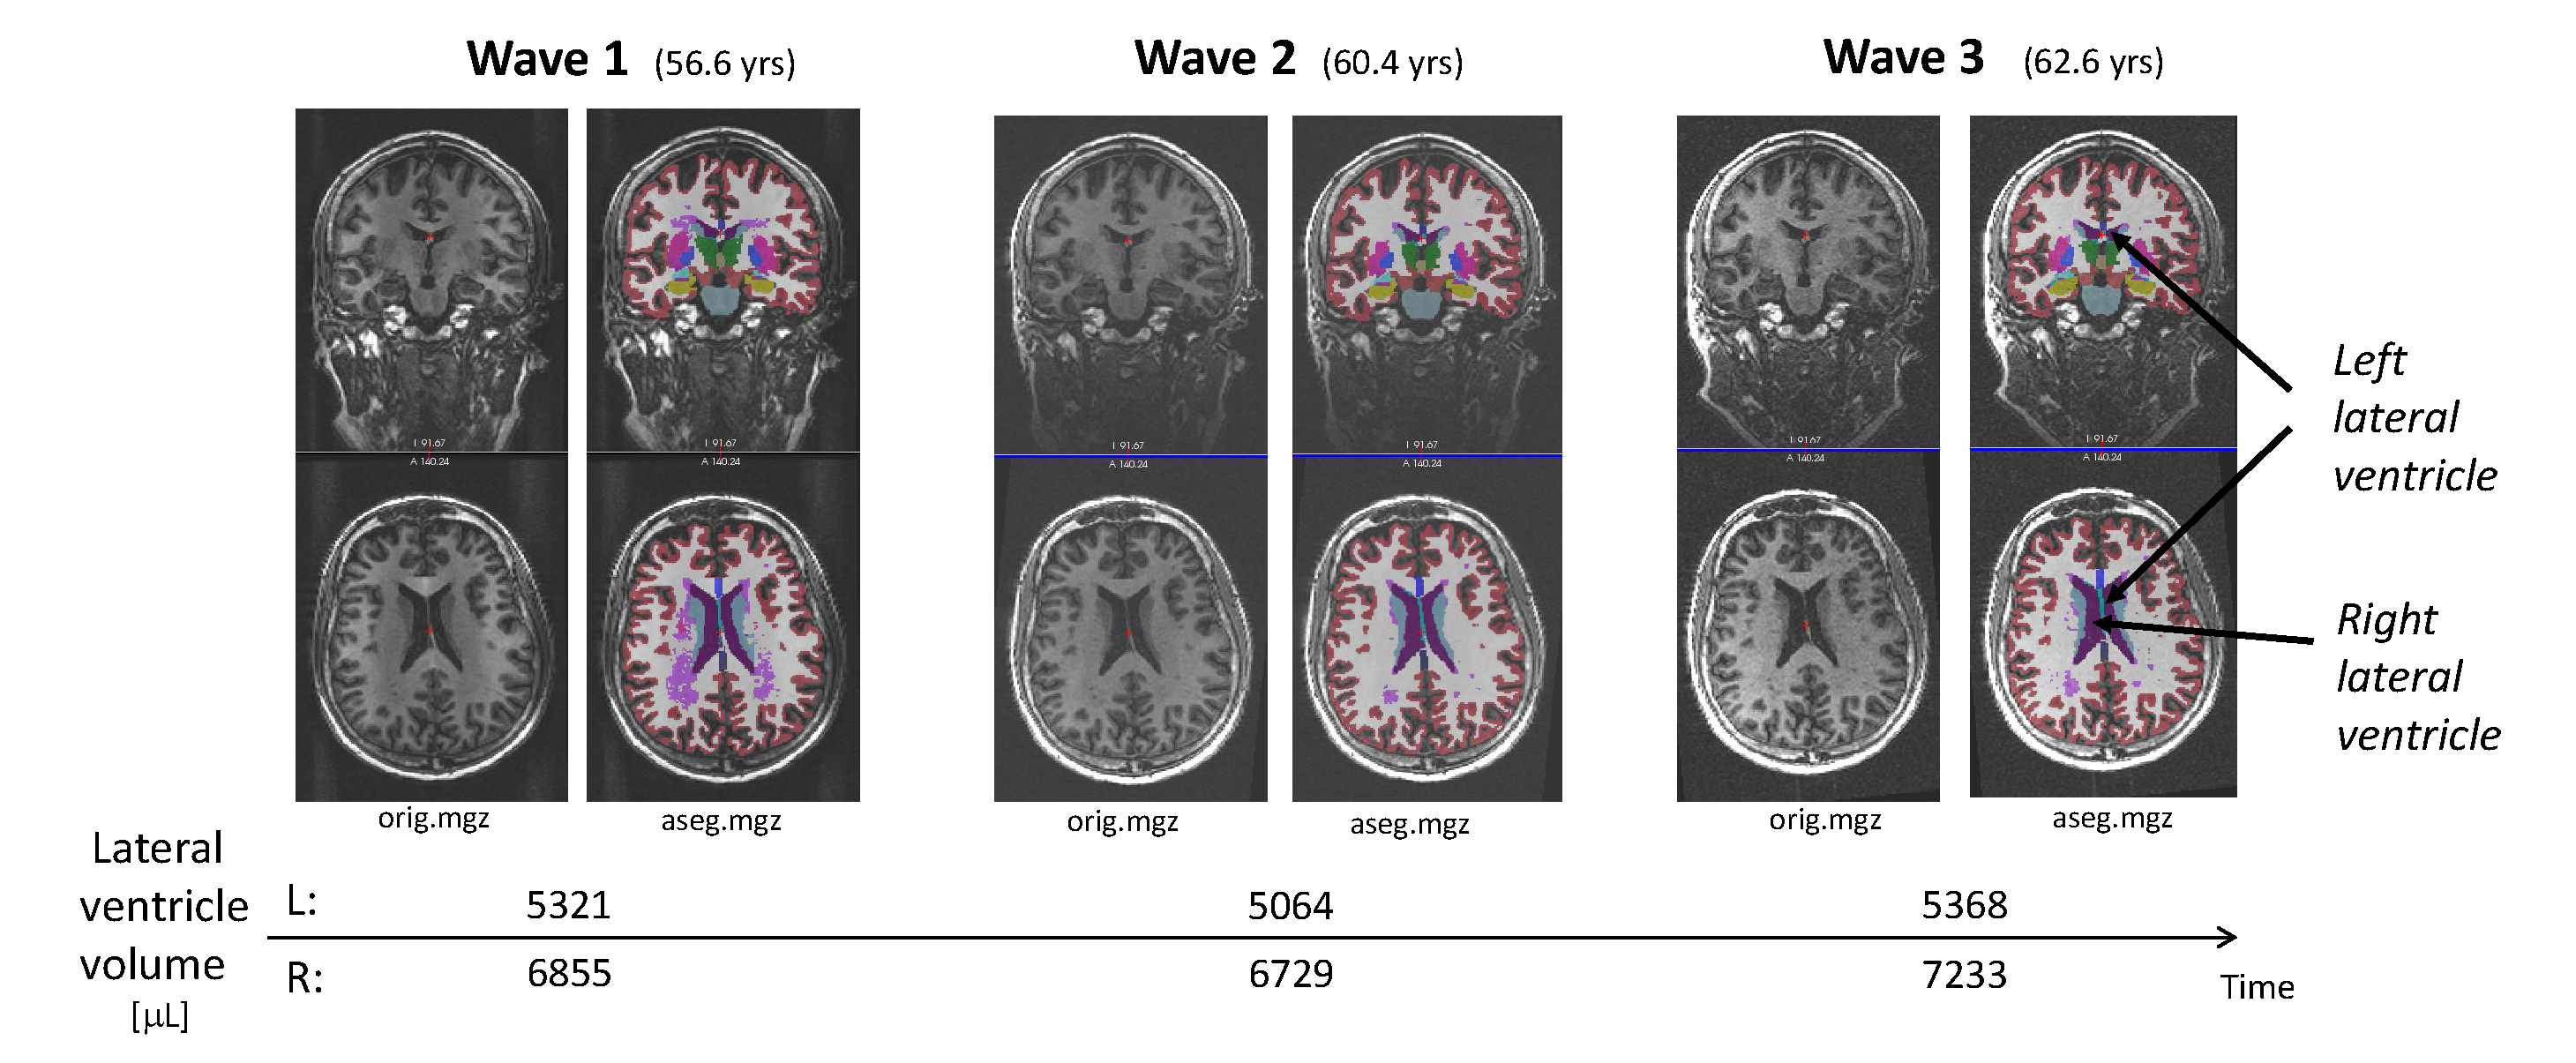

In [3]:
from IPython.display import Image
Image(filename='../images/Figure_1.png', width=800)

In [4]:
fn_data = '../data/lvv_ri_data.csv'
df = pd.read_csv(fn_data)

### Explore data

In [5]:
df.shape

(74, 12)

In [6]:
#for col in df.columns:
#    print(col)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 12 columns):
Subject                       74 non-null object
Sex                           74 non-null object
AcquisitionYearsW1            74 non-null float64
AcquisitionYearsW2            74 non-null float64
AcquisitionYearsW3            74 non-null float64
Left-Lateral-Ventricle_W1     74 non-null float64
Left-Lateral-Ventricle_W2     74 non-null float64
Left-Lateral-Ventricle_W3     74 non-null float64
Right-Lateral-Ventricle_W1    74 non-null float64
Right-Lateral-Ventricle_W2    74 non-null float64
Right-Lateral-Ventricle_W3    74 non-null float64
Stroop_3_R_W3                 74 non-null float64
dtypes: float64(10), object(2)
memory usage: 7.0+ KB


In [7]:
df.head(5).T

,0,1,2,3,4
Subject,subj_01,subj_02,subj_03,subj_04,subj_05
Sex,F,M,M,M,M
AcquisitionYearsW1,56.63,49.07,74.61,56.23,63.22
AcquisitionYearsW2,60.35,52.58,78.14,59.78,67
AcquisitionYearsW3,62.62,55.05,80.59,62.68,69.53
Left-Lateral-Ventricle_W1,5321.4,11038.6,29718.4,21830.1,17205.1
Left-Lateral-Ventricle_W2,5063.6,11912.2,32265.1,23933.6,16970.1
Left-Lateral-Ventricle_W3,5368.3,12313.3,35887,26164.2,15858.1
Right-Lateral-Ventricle_W1,6855.2,10611.6,34241,15243.9,13962.1
Right-Lateral-Ventricle_W2,6729.2,11774.8,37155.2,16505.1,13755.5


In [8]:
df.describe(percentiles = [.5]).T.round(2)

,count,mean,std,min,50%,max
AcquisitionYearsW1,74.0,60.75,7.25,46.66,59.88,77.63
AcquisitionYearsW2,74.0,64.28,7.21,50.11,63.56,81.33
AcquisitionYearsW3,74.0,66.81,7.19,52.46,66.02,84.05
Left-Lateral-Ventricle_W1,74.0,14994.10,8584.68,5303.10,12259.60,54646.70
Left-Lateral-Ventricle_W2,74.0,16450.17,9589.52,5063.60,13288.65,58559.10
Left-Lateral-Ventricle_W3,74.0,17605.22,10354.05,5235.00,14225.50,61501.40
Right-Lateral-Ventricle_W1,74.0,13777.28,7743.45,4408.30,12181.85,40721.30
Right-Lateral-Ventricle_W2,74.0,15183.76,8738.59,3777.00,13089.90,47038.50
Right-Lateral-Ventricle_W3,74.0,16381.11,9646.09,3810.20,13732.20,52859.40
Stroop_3_R_W3,74.0,56.99,14.46,35.00,54.50,102.00


In [9]:
df.describe(include=[np.object])

,Subject,Sex
count,74,74
unique,74,2
top,subj_61,F
freq,1,48


 ## Using lmer in R for linear mixed-effects analysis

In [10]:
%reload_ext rpy2.ipython

In [11]:
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
from rpy2.robjects.packages import importr
utils = importr('utils')
# If needed to install - uncomment the following
#utils.install_packages('tidyr')
#utils.install_packages('lme4')
#utils.install_packages('caret')
#utils.install_packages('tidyverse')
#utils.install_packages('devtools')
#utils.install_packages('rlang')
#utils.install_packages('Rccp')
#utils.install_packages('GGally')
#utils.install_packages('tikzDevice')
#utils.install_packages('stargazer')
#utils.install_packages('readxl')
#utils.install_packages('ggplot2')
#utils.install_packages('stringi')

In [14]:
%R R.version$system

array(['x86_64, darwin13.4.0'], dtype='<U20')

In [15]:
%R R.version$version.string

array(['R version 3.4.3 (2017-11-30)'], dtype='<U28')

In [16]:
%R library(rlang); library(Rcpp); library(stargazer); library(readxl); library(ggplot2)
# %R library(rlang); library(Rcpp); library(tidyverse); library(stargazer)   stringi is missing


Error in library(stargazer) : there is no package called ‘stargazer’


#### Make long format

In [17]:
%%R -i df

# df.all <- read.table(file="../data/lvv_ri_data.csv", header=TRUE, sep=",")
df.all <- df

mycols1 = c('Subject','AcquisitionYearsW1', 'AcquisitionYearsW2', 'AcquisitionYearsW3')
mycols2 = c('Subject','Left.Lateral.Ventricle_W1','Left.Lateral.Ventricle_W2', 'Left.Lateral.Ventricle_W3')
mycols3 = c('Subject','Right.Lateral.Ventricle_W1','Right.Lateral.Ventricle_W2', 'Right.Lateral.Ventricle_W3')

df.sel1 <- select(df.all, mycols1)
df.sel2 <- select(df.all, mycols2)
df.sel3 <- select(df.all, mycols3)
                  
df.long1 <- gather(df.sel1, Wave, Age, AcquisitionYearsW1:AcquisitionYearsW3, factor_key=TRUE)
levels(df.long1$Wave)[levels(df.long1$Wave)=="AcquisitionYearsW1"] <- "1"
levels(df.long1$Wave)[levels(df.long1$Wave)=="AcquisitionYearsW2"] <- "2"
levels(df.long1$Wave)[levels(df.long1$Wave)=="AcquisitionYearsW3"] <- "3"

df.long2 <- gather(df.sel2, Wave, Volume, Left.Lateral.Ventricle_W1:Left.Lateral.Ventricle_W3, factor_key=TRUE)
levels(df.long2$Wave)[levels(df.long2$Wave)=="Left.Lateral.Ventricle_W1"] <- "1"
levels(df.long2$Wave)[levels(df.long2$Wave)=="Left.Lateral.Ventricle_W2"] <- "2"
levels(df.long2$Wave)[levels(df.long2$Wave)=="Left.Lateral.Ventricle_W3"] <- "3"

df.long3 <- gather(df.sel3, Wave, Volume, Right.Lateral.Ventricle_W1:Right.Lateral.Ventricle_W3, factor_key=TRUE)
levels(df.long3$Wave)[levels(df.long3$Wave)=="Right.Lateral.Ventricle_W1"] <- "1"
levels(df.long3$Wave)[levels(df.long3$Wave)=="Right.Lateral.Ventricle_W2"] <- "2"
levels(df.long3$Wave)[levels(df.long3$Wave)=="Right.Lateral.Ventricle_W3"] <- "3"

df.longL <- merge(x = df.long1, y = df.long2, by.x = c("Subject","Wave"), by.y = c("Subject","Wave"))
df.longR <- merge(x = df.long1, y = df.long3, by.x = c("Subject","Wave"), by.y = c("Subject","Wave"))

# Left: Sort by Subject first, then by Wave
df.longL <- df.longL[order(df.longL$Subject, df.longL$Wave), ]
df.longL$Region <- "LeftLateralVentricle"
# Reorder columns
df.longL$Subject = substr(df.longL$Subject, start=6, stop=7)
df.longL <- df.longL[c("Subject", "Region", "Wave", "Age", "Volume")]
# https://support.rstudio.com/hc/en-us/articles/205175388-Using-the-Data-Viewer
#View(df.long))

# Right: Sort by Subject first, then by Wave
df.longR <- df.longR[order(df.longR$Subject, df.longR$Wave), ]
df.longR$Region <- "RightLateralVentricle"
# Reorder columns
df.longR$Subject = substr(df.longR$Subject, start=6, stop=7)
df.longR <- df.longR[c("Subject", "Region", "Wave", "Age", "Volume")]


In [18]:
%R names(df.longR)

array(['Subject', 'Region', 'Wave', 'Age', 'Volume'], dtype='<U7')

In [19]:
%R head(df.longR)

,Subject,Region,Wave,Age,Volume
0,01,RightLateralVentricle,1,56.63,6855.2
1,01,RightLateralVentricle,2,60.35,6729.2
2,01,RightLateralVentricle,3,62.62,7233.2
3,02,RightLateralVentricle,1,49.07,10611.6
4,02,RightLateralVentricle,2,52.58,11774.8
5,02,RightLateralVentricle,3,55.05,12070.5


In [20]:
# Converting the R dataframes to Pandas DataFrames using Rpy2
# https://pandas.pydata.org/pandas-docs/stable/r_interface.html
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

pd_df_long_L = r['df.longL']
print(pd_df_long_L.head())

pd_df_long_R = r['df.longR']
pd_df_long_R.head().round(2)

  Subject                Region Wave    Age   Volume
0      01  LeftLateralVentricle    1  56.63   5321.4
1      01  LeftLateralVentricle    2  60.35   5063.6
2      01  LeftLateralVentricle    3  62.62   5368.3
3      02  LeftLateralVentricle    1  49.07  11038.6
4      02  LeftLateralVentricle    2  52.58  11912.2


,Subject,Region,Wave,Age,Volume
0,01,RightLateralVentricle,1,56.63,6855.2
1,01,RightLateralVentricle,2,60.35,6729.2
2,01,RightLateralVentricle,3,62.62,7233.2
3,02,RightLateralVentricle,1,49.07,10611.6
4,02,RightLateralVentricle,2,52.58,11774.8


In [21]:
pd_df_long_L.describe()

,Age,Volume
count,222.000000,222.000000
mean,63.948243,16349.831081
std,7.604560,9553.919138
min,46.660000,5063.600000
25%,58.847500,10013.250000
50%,63.255000,13549.400000
75%,69.375000,20050.225000
max,84.050000,61501.400000


### Fit linear ordinary least squares (OLS) and mixed-effects models for Left and Right hemisphere

In [22]:
%%R
library(lme4)

lm.1.L <- lm(Volume ~ Age, data = df.longL)
lmer.1.L <- lmer(Volume ~ Age + (Age | Subject), data=df.longL, REML=TRUE)

lm.1.R <- lm(Volume ~ Age, data = df.longR)
lmer.1.R <- lmer(Volume ~ Age + (Age | Subject), data=df.longR, REML=TRUE)

In [23]:
%%R

# Left
mylm <- lm.1.L
mylmer <- lmer.1.L

# Get the coefficients of fixed and random effects
a0.L <- coef(mylm)[[1]]
a1.L <- coef(mylm)[[2]]
beta0.L <- fixef(mylmer)[[1]]
beta1.L <- fixef(mylmer)[[2]]
b.L <- ranef(mylmer)
b0i.L <- b.L$Subject[,1]
b1i.L <- b.L$Subject[,2]


beta01.L = sprintf("Fixed effects (left LV): beta0.L = %.2f ; beta1.L = %.2f", beta0.L, beta1.L)

df.lmer.L <- merge(x = df.sel1, y = df.sel2, by.x = c("Subject"), by.y = c("Subject"))
df.lmer.L$b0i <- b0i.L
df.lmer.L$b1i <- b1i.L
df.lmer.L$beta0plusb0i <- b0i.L + beta0.L
df.lmer.L$beta1plusb1i <- b1i.L + beta1.L

df.lmer.L$Sex <- df.all$Sex
#df.lmer.L$eTIVw1 <- df.all$EstimatedTotalIntraCranialVol_W1
#df.lmer.L$eTIVw2 <- df.all$EstimatedTotalIntraCranialVol_W2
#df.lmer.L$eTIVw3 <- df.all$EstimatedTotalIntraCranialVol_W3
#df.lmer.L$Stroop1 <- df.all$Stroop_1_R_W3
#df.lmer.L$Stroop2 <- df.all$Stroop_2_R_W3 
df.lmer.L$Stroop3 <- df.all$Stroop_3_R_W3 
#df.lmer.L$Stroop4 <- df.all$Stroop_4_R_W3 
#df.lmer.L$IQtot <- df.all$IQ_total_W1

In [24]:
%R print(head(df.lmer.L, 3))

  Subject AcquisitionYearsW1 AcquisitionYearsW2 AcquisitionYearsW3
1 subj_01              56.63              60.35              62.62
2 subj_02              49.07              52.58              55.05
3 subj_03              74.61              78.14              80.59
  Left.Lateral.Ventricle_W1 Left.Lateral.Ventricle_W2 Left.Lateral.Ventricle_W3
1                    5321.4                    5063.6                    5368.3
2                   11038.6                   11912.2                   12313.3
3                   29718.4                   32265.1                   35887.0
        b0i       b1i beta0plusb0i beta1plusb1i Sex Stroop3
1  15786.39 -403.1431    3728.3106     25.58843   F      66
2  11459.87 -192.3109    -598.2127    236.42067   M      85
3 -27879.94  504.2479  -39938.0243    932.97950   M      71


In [25]:
%R print(beta01.L)

[1] "Fixed effects (left LV): beta0.L = -12058.08 ; beta1.L = 428.73"


In [26]:
%%R

# Right
mylm <- lm.1.R
mylmer <- lmer.1.R


a0.R <- coef(mylm)[[1]]
a1.R <- coef(mylm)[[2]]
beta0.R <- fixef(mylmer)[[1]]
beta1.R <- fixef(mylmer)[[2]]
b.R <- ranef(mylmer)
b0i.R <- b.R$Subject[,1]
b1i.R <- b.R$Subject[,2]

beta01.R = sprintf("Fixed effects (right LV): beta0.R = %.2f ; beta1.R = %.2f", beta0.R, beta1.R)

df.lmer.R <- merge(x = df.sel1, y = df.sel3, by.x = c("Subject"), by.y = c("Subject"))
df.lmer.R$b0i <- b0i.R
df.lmer.R$b1i <- b1i.R
df.lmer.R$beta0plusb0i <- b0i.R + beta0.R
df.lmer.R$beta1plusb1i <- b1i.R + beta1.R

df.lmer.R$Sex <- df.all$Sex
#df.lmer.R$eTIVw1 <- df.all$EstimatedTotalIntraCranialVol_W1
#df.lmer.R$eTIVw2 <- df.all$EstimatedTotalIntraCranialVol_W2
#df.lmer.R$eTIVw3 <- df.all$EstimatedTotalIntraCranialVol_W3
#df.lmer.R$Stroop1 <- df.all$Stroop_1_R_W3
#df.lmer.R$Stroop2 <- df.all$Stroop_2_R_W3 
df.lmer.R$Stroop3 <- df.all$Stroop_3_R_W3 
#df.lmer.R$Stroop4 <- df.all$Stroop_4_R_W3 
#df.lmer.R$IQtot <- df.all$IQ_total_W1


In [27]:
%R print(beta01.R)

[1] "Fixed effects (right LV): beta0.R = -13239.56 ; beta1.R = 425.99"


In [28]:
# %R print(stargazer(lmer.1.L))

### Plotting lmer model using ggplot

In [29]:
%%R

# Left lateral ventricle

df <-  df.longL

title.1.L <- "Left lateral ventricle"

# if(.Platform$OS.type == "unix") {
#   myfile.1.L <- "~/GitHub/mri-stroop/manus/Figs/10_lmer_LeftLateralVentricle_R.pdf"
#   mytexfig.1.L <- "~/GitHub/mri-stroop/manus/Figs/10_lmer_LeftLateralVentricle_tikz.tex"
# } else if (.Platform$OS.type == "Darwin") {
#   myfile.1.L <- "~/GitHub/mri-stroop/manus/Figs/10_lmer_LeftLateralVentricle_R.pdf"
#   mytexfig.1.L <- "~/GitHub/mri-stroop/manus/Figs/10_lmer_LeftLateralVentricle_tikz.tex"
# } else {
#   myfile.1.L <- "C:/Users/arvid/GitHub/mri-stroop/manus/Figs/10_lmer_LeftLateralVentricle_R.pdf"
#   mytexfig.1.L <- "C:/Users/arvid/GitHub/mri-stroop/manus/Figs/10_lmer_LeftLateralVentricle_tikz.tex"
# }
# mytexfigg.1.L <- "10_lmer_LeftLateralVentricle_tikz.tex"


#mylm <- lm.1.L
#mylmer <- lmer.1.L
mytitle <- title.1.L
#myfile <- myfile.1.L
#mytexfig <- mytexfig.1.L
#mytexfigg <- mytexfigg.1.L

g11 <- ggplot(data = df, aes(x = Age, y = Volume, group = Subject, colour = factor(Subject))) + geom_line(size=2)
# g11 <- g11 + scale_colour_discrete(name  ="Subject") + geom_point(pch=19, size = 4)
g11 <- g11 + scale_colour_discrete(name  ="Subject") + geom_point(pch=19, size = 5)
myX <- scale_x_continuous(limits = c(45, 85), breaks = seq(45, 85, 5), name = "Age [yrs]")
myY <- scale_y_continuous(limits = c(500, 65000), breaks = seq(0, 65000, 5000), name = "Volume\n [microL]") 
# annottext1 <- paste("$\\hat{\\beta_0}=", round(beta0, 2), '; \\hat{\\beta_1}=', round(beta1, 2), '$', sep='')
# annottext <- paste("${\\rm Vol}_{ij} = \\beta_0 + \\beta_1 {\\rm Age}_{ij} + (b_{0i} + b_{1i} {\\rm Age}_{ij}) + \\epsilon_{ij}$ where", annottext1, sep=" ")

#g11 <- g11 + annotate("text", x=65, y=1000,label= annottext, colour="black")
g11 <- g11 + geom_point(size = 1.0) + theme_bw() + myX + myY
#g11 <- g11 + geom_abline(intercept = a0, slope = a1, linetype = "dashed", size=2.0, colour = "red")
#g11 <- g11 + geom_abline(intercept = beta0, slope = beta1, linetype = "solid", size=2.0, colour = "black")
g11 <- g11 + labs(title = mytitle, fontsize = 32)
# Set title to twice the base font size
g11 <- g11 + theme(plot.title = element_text(size = rel(2.0)))
g11 <- g11 + theme(axis.line = element_line(size = 1, colour = "black", linetype = "solid"))
g11 <- g11 + theme(axis.text = element_text(size = rel(1.5)))
g11 <- g11 + theme(axis.title.y = element_text(size = rel(1.8), angle = 0))
g11 <- g11 + theme(axis.title.x = element_text(size = rel(1.8), angle = 0))
# g11 <- g11 + theme(legend.key = element_rect(colour = "black"))
# g11 <- g11 + theme(legend.title = element_text(size = rel(1.2), face = "italic"))
g11 <- g11 + theme(panel.grid.major = element_line(colour = "gray70"))
g11 <- g11 + theme(panel.grid.minor = element_line(colour = "gray80", linetype = "dotted"))
g11 <- g11 + theme(plot.background = element_rect(fill = "white"))

g11 <- g11 + theme(axis.text.x=element_text(size=24), axis.title.x=element_text(size=24,face="bold"))
g11 <- g11 + theme(axis.text.y=element_text(size=20), axis.title.y=element_text(size=24,face="bold"))
g11 <- g11 + theme(plot.title = element_text(size=28))
                   
# # Focus on individual trajectories; first fit a simple linear model to each trajectory
# #g11 <- g11 + stat_smooth(method=lm, fullrange=FALSE, se=FALSE, linetype = "dashed")
# # then add the mixed-effects fit
# n <- length(b0i)
# for (i in 1:n) {
#   myx <-  df$Age[df$Wave==1][i]
#   myxend <- df$Age[df$Wave==3][i]
#   myy <- (beta0 + b0i[i]) + (beta1 + b1i[i])*myx
#   myyend <- (beta0 + b0i[i]) + (beta1 + b1i[i])*myxend
#   g11 <- g11 + annotate("segment", x = myx, xend = myxend, y = myy, yend = myyend, colour = "black", size = 0.3)
# }
  
ggsave("../images/lvv_ri_rpy2_left_ventricle.pdf", width = 40, height = 30, units = "cm")
ggsave("../images/lvv_ri_rpy2_left_ventricle.png", width = 40, height = 30, units = "cm")


Error in ggplot(data = df, aes(x = Age, y = Volume, group = Subject, colour = factor(Subject))) : 
  could not find function "ggplot"


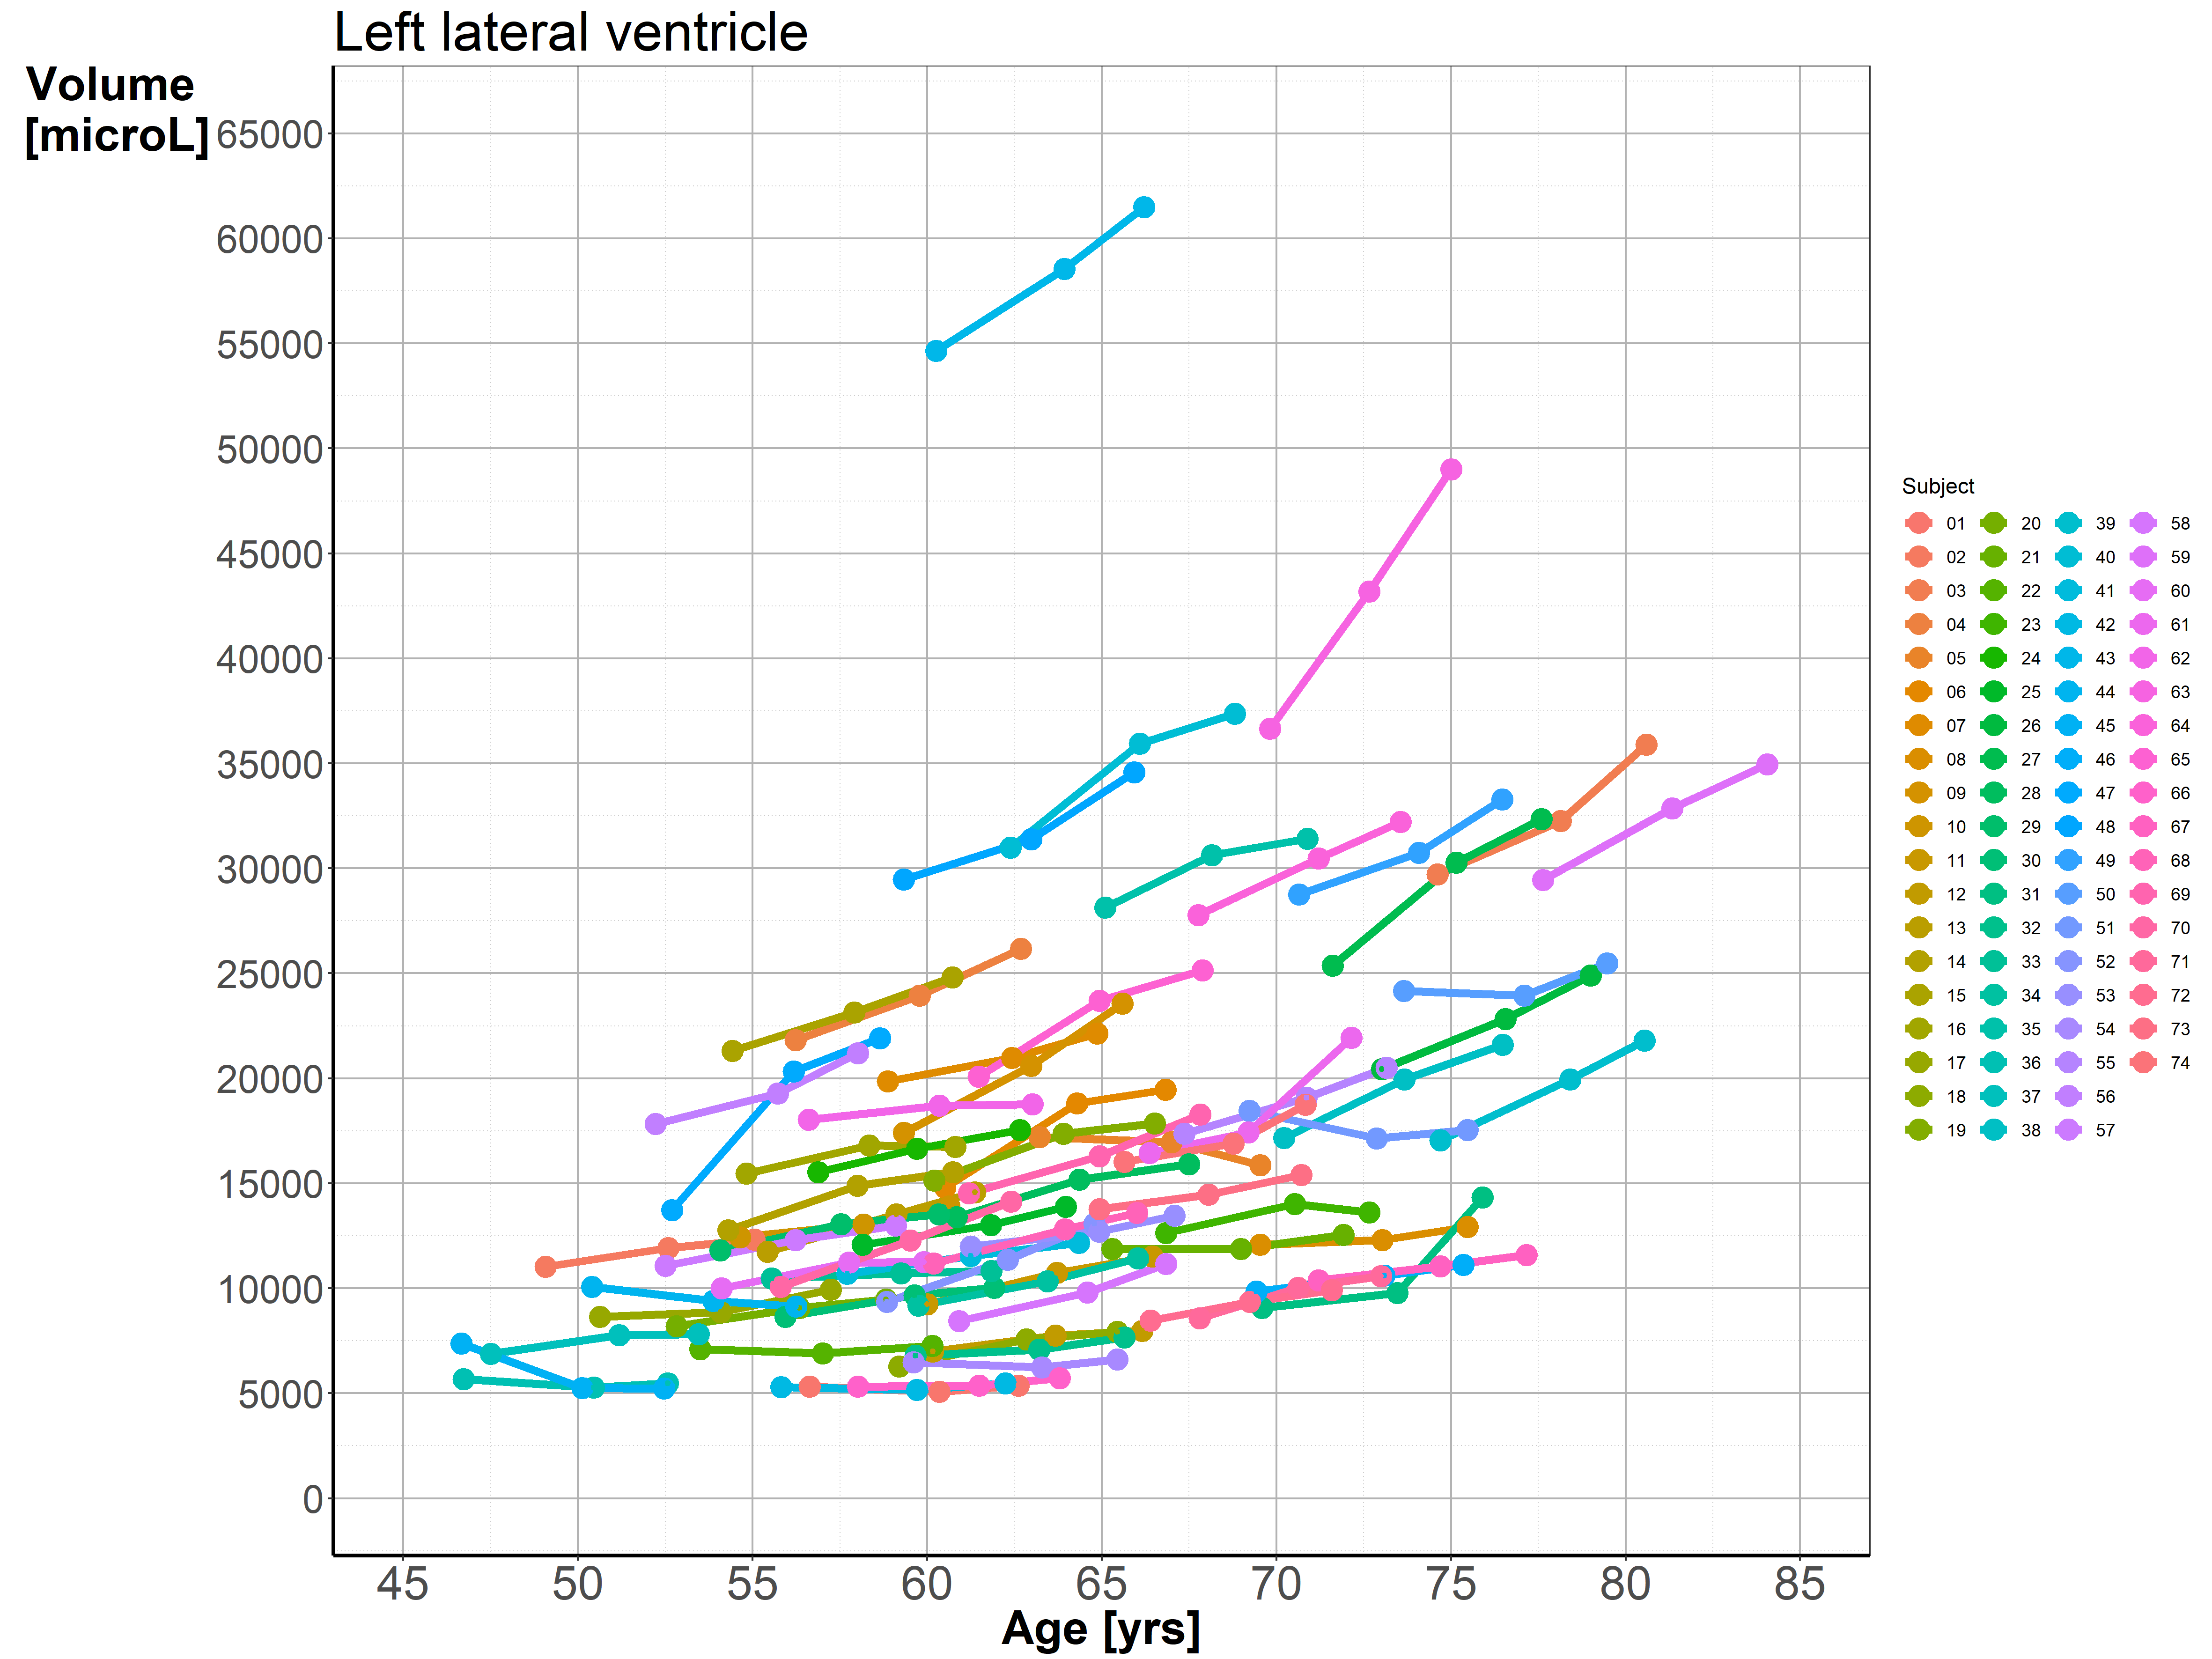

In [30]:
# %R print(g11)
Image(filename='../images/lvv_ri_rpy2_left_ventricle.png', width=900)

In [31]:
%%R

# Right lateral ventricle

df <-  df.longR

title.1.R <- "Right lateral ventricle"

# if(.Platform$OS.type == "unix") {
#   myfile.1.R <- "~/GitHub/mri-stroop/manus/Figs/10_lmer_RightLateralVentricle_R.pdf"
#   mytexfig.1.R <- "~/GitHub/mri-stroop/manus/Figs/10_lmer_RightLateralVentricle_tikz.tex"
# } else if (.Platform$OS.type == "Darwin") {
#   myfile.1.R <- "~/GitHub/mri-stroop/manus/Figs/10_lmer_RightLateralVentricle_R.pdf"
#   mytexfig.1.R <- "~/GitHub/mri-stroop/manus/Figs/10_lmer_RightLateralVentricle_tikz.tex"
# } else {
#   myfile.1.R <- "C:/Users/arvid/GitHub/mri-stroop/manus/Figs/10_lmer_RightLateralVentricle_R.pdf"
#   mytexfig.1.R <- "C:/Users/arvid/GitHub/mri-stroop/manus/Figs/10_lmer_RightLateralVentricle_tikz.tex"
# }
# mytexfigg.1.R <- "10_lmer_RightLateralVentricle_tikz.tex"

#mylm <- lm.1.R
#mylmer <- lmer.1.R
mytitle <- title.1.R
#myfile <- myfile.1.R
#mytexfig <- mytexfig.1.R
#mytexfigg <- mytexfigg.1.R

g12 <- ggplot(data = df, aes(x = Age, y = Volume, group = Subject, colour = factor(Subject))) + geom_line(size=2)
# g11 <- g11 + scale_colour_discrete(name  ="Subject") + geom_point(pch=19, size = 4)
g12 <- g12 + scale_colour_discrete(name  ="Subject") + geom_point(pch=19, size = 5)
myX <- scale_x_continuous(limits = c(45, 85), breaks = seq(45, 85, 5), name = "Age [yrs]")
myY <- scale_y_continuous(limits = c(500, 65000), breaks = seq(0, 65000, 5000), name = "Volume\n [microL]") 
# annottext1 <- paste("$\\hat{\\beta_0}=", round(beta0, 2), '; \\hat{\\beta_1}=', round(beta1, 2), '$', sep='')
# annottext <- paste("${\\rm Vol}_{ij} = \\beta_0 + \\beta_1 {\\rm Age}_{ij} + (b_{0i} + b_{1i} {\\rm Age}_{ij}) + \\epsilon_{ij}$ where", annottext1, sep=" ")

#g11 <- g11 + annotate("text", x=65, y=1000,label= annottext, colour="black")
g12 <- g12 + geom_point(size = 1.0) + theme_bw() + myX + myY
#g11 <- g11 + geom_abline(intercept = a0, slope = a1, linetype = "dashed", size=2.0, colour = "red")
#g11 <- g11 + geom_abline(intercept = beta0, slope = beta1, linetype = "solid", size=2.0, colour = "black")
g12 <- g12 + labs(title = mytitle, fontsize = 32)
# Set title to twice the base font size
g12 <- g12 + theme(plot.title = element_text(size = rel(2.0)))
g12 <- g12 + theme(axis.line = element_line(size = 1, colour = "black", linetype = "solid"))
g12 <- g12 + theme(axis.text = element_text(size = rel(1.5)))
g12 <- g12 + theme(axis.title.y = element_text(size = rel(1.8), angle = 0))
g12 <- g12 + theme(axis.title.x = element_text(size = rel(1.8), angle = 0))
# g12 <- g12 + theme(legend.key = element_rect(colour = "black"))
# g12 <- g12 + theme(legend.title = element_text(size = rel(1.2), face = "italic"))
g12 <- g12 + theme(panel.grid.major = element_line(colour = "gray70"))
g12 <- g12 + theme(panel.grid.minor = element_line(colour = "gray80", linetype = "dotted"))
g12 <- g12 + theme(plot.background = element_rect(fill = "white"))

g12 <- g12 + theme(axis.text.x=element_text(size=24), axis.title.x=element_text(size=24,face="bold"))
g12 <- g12 + theme(axis.text.y=element_text(size=20), axis.title.y=element_text(size=24,face="bold"))
g12 <- g12 + theme(plot.title = element_text(size=28))
                   
                   
# # Focus on individual trajectories; first fit a simple linear model to each trajectory
# #g11 <- g11 + stat_smooth(method=lm, fullrange=FALSE, se=FALSE, linetype = "dashed")
# # then add the mixed-effects fit
# n <- length(b0i)
# for (i in 1:n) {
#   myx <-  df$Age[df$Wave==1][i]
#   myxend <- df$Age[df$Wave==3][i]
#   myy <- (beta0 + b0i[i]) + (beta1 + b1i[i])*myx
#   myyend <- (beta0 + b0i[i]) + (beta1 + b1i[i])*myxend
#   g11 <- g11 + annotate("segment", x = myx, xend = myxend, y = myy, yend = myyend, colour = "black", size = 0.3)
# }
  
ggsave("../images/lvv_ri_rpy2_right_ventricle.pdf", width = 40, height = 30, units = "cm")
ggsave("../images/lvv_ri_rpy2_right_ventricle.png", width = 40, height = 30, units = "cm")


Error in ggplot(data = df, aes(x = Age, y = Volume, group = Subject, colour = factor(Subject))) : 
  could not find function "ggplot"


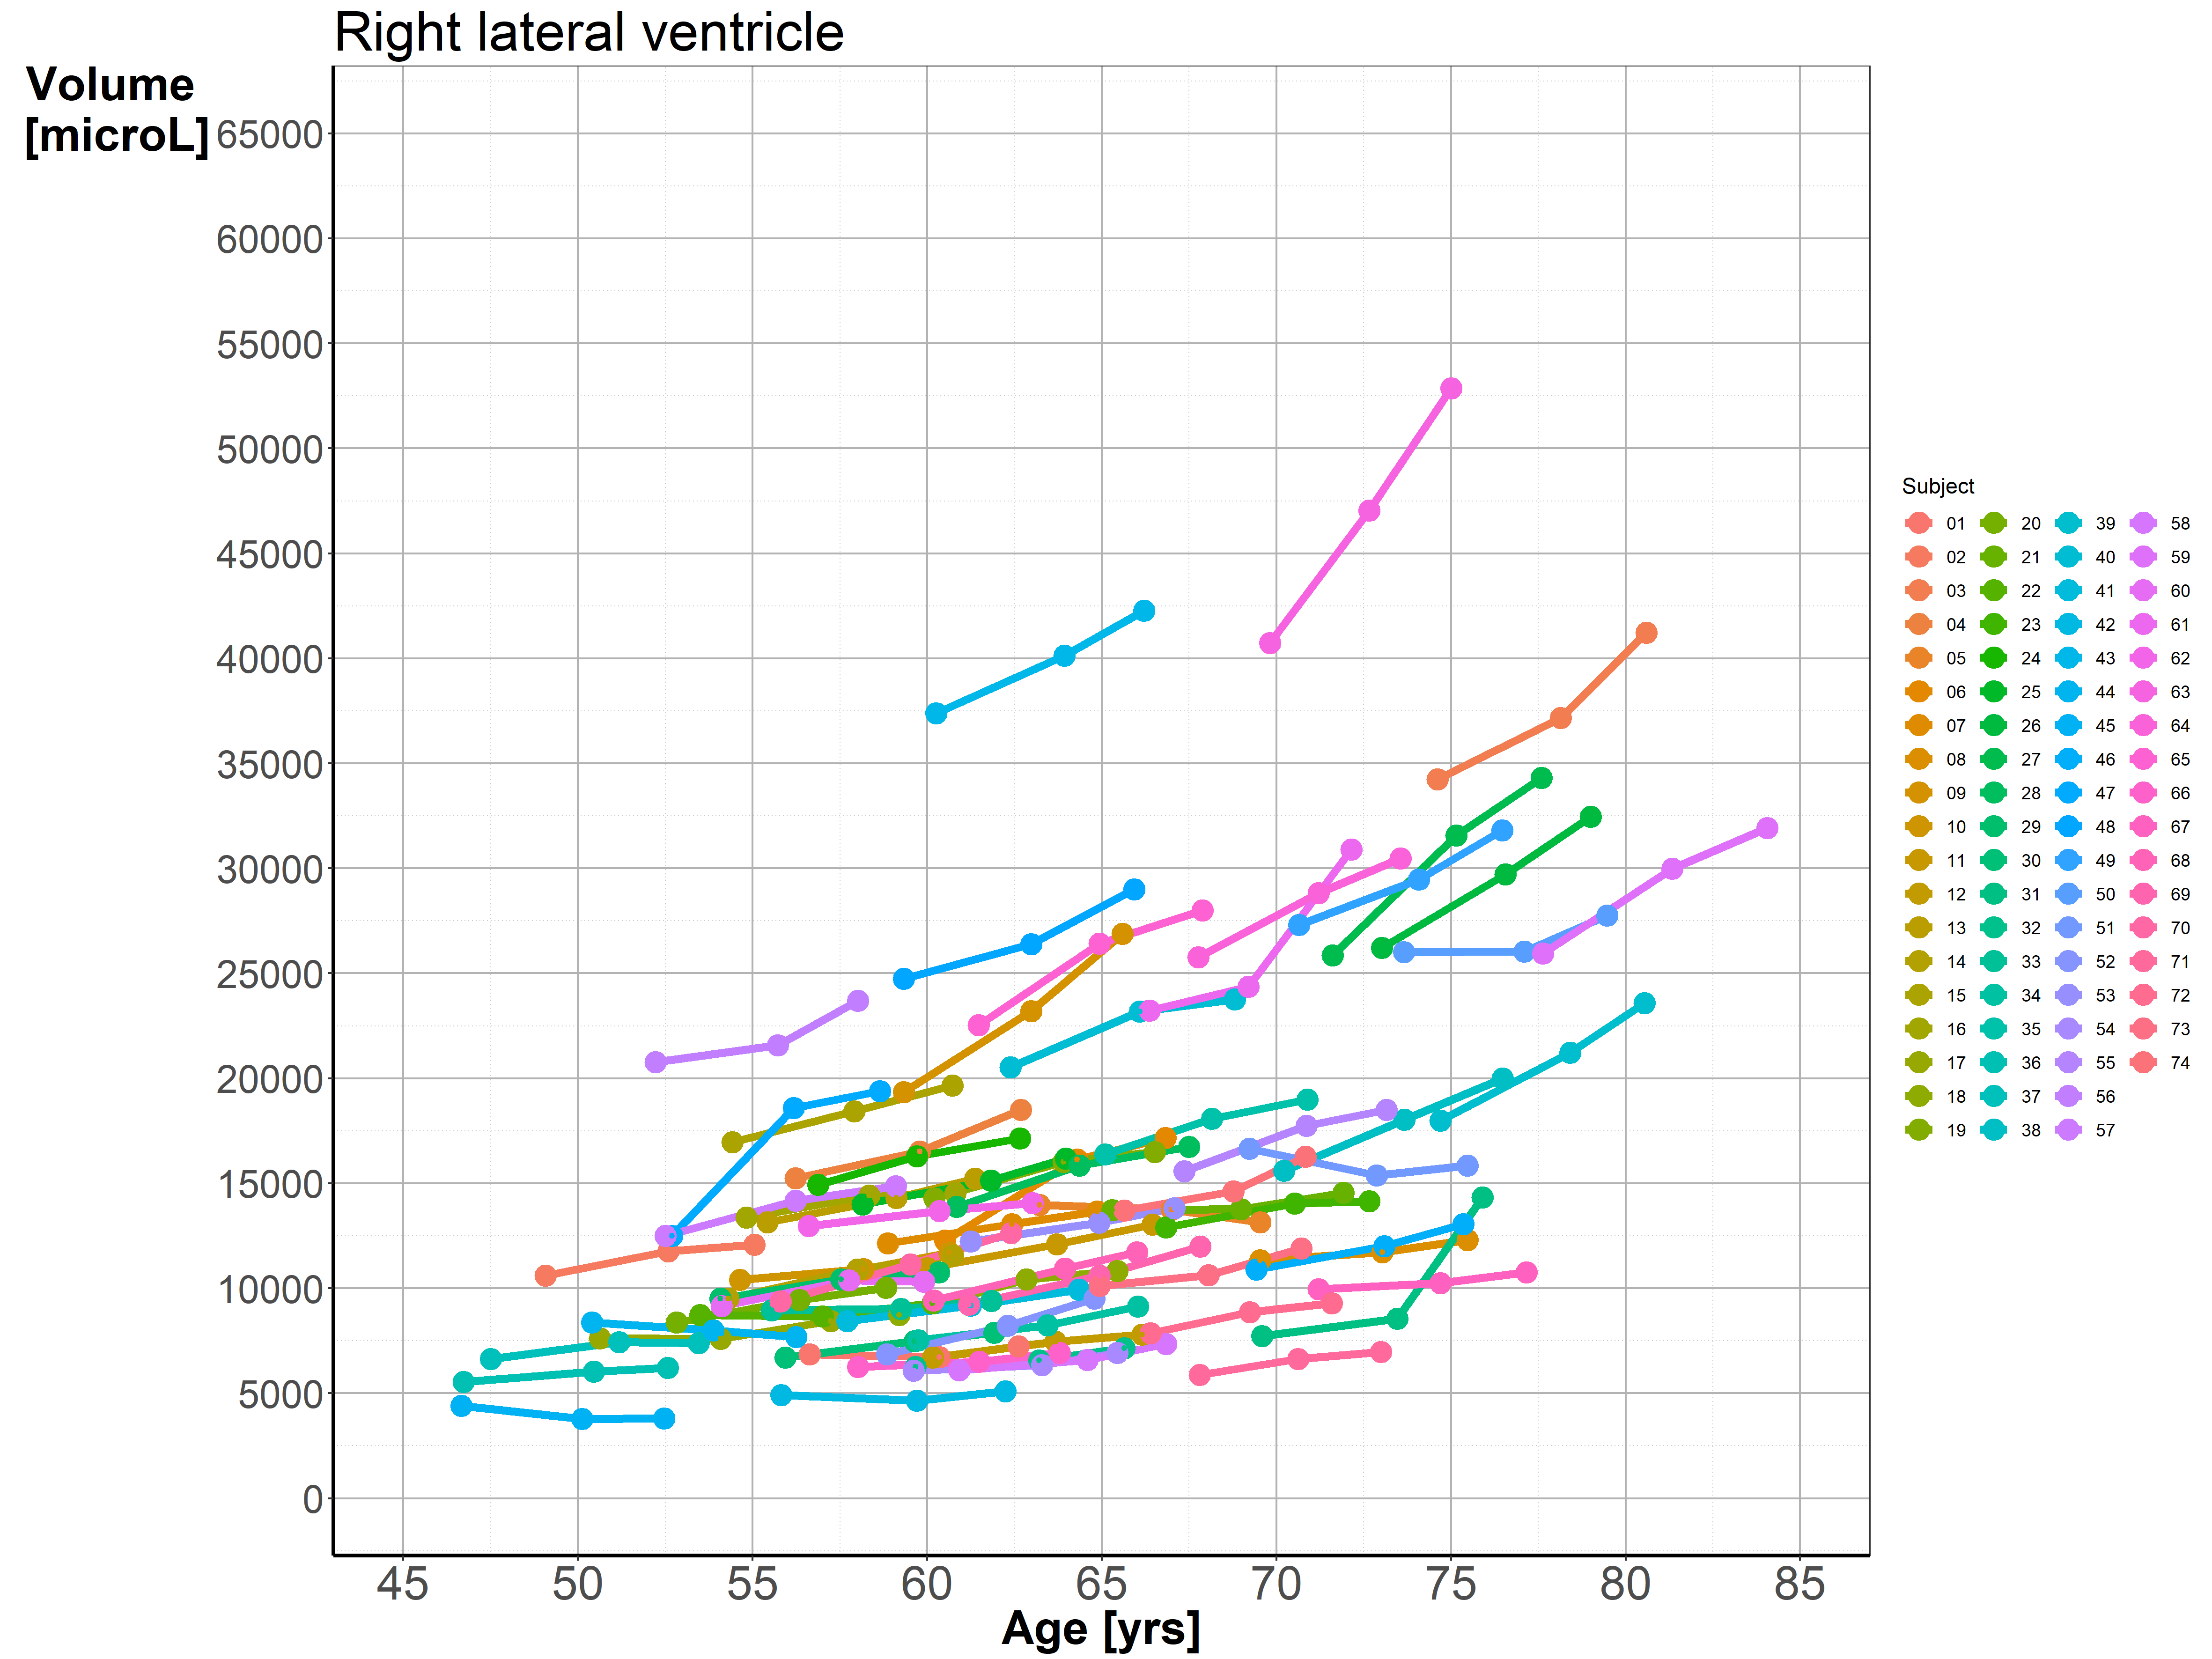

In [32]:
# %R plot(g12)
Image(filename='../images/lvv_ri_rpy2_right_ventricle.png', width=900)

In [33]:
%%R

df <-  df.longL
mylm <- lm.1.L
mylmer <- lmer.1.L
mytitle <- title.1.L
#myfile <- myfile.1.L
#mytexfig <- mytexfig.1.L
#mytexfigg <- mytexfigg.1.L

g21 <- ggplot(data = df, aes(x = Age, y = Volume, group = Subject, colour = factor(Subject))) + geom_line(size=1)
# g11 <- g11 + scale_colour_discrete(name  ="Subject") + geom_point(pch=19, size = 4)
g21 <- g21 + scale_colour_discrete(name  ="Subject") + geom_point(pch=19, size = 4)
myX <- scale_x_continuous(limits = c(45, 85), breaks = seq(45, 85, 5), name = "Age [yrs]")
myY <- scale_y_continuous(limits = c(500, 65000), breaks = seq(0, 65000, 5000), name = "Volume\n [microL]")
# annottext <- paste("$\\hat{\\beta_0}=", round(beta0, 4), '; \\hat{\\beta_1}=', round(beta1, 5), '$', sep='') 
#annottext1 <- paste("$\\hat{\\beta_0}=", round(beta0, 2), '; \\hat{\\beta_1}=', round(beta1, 2), '$', sep='')
#annottext <- paste("${\\rm Vol}_{ij} = \\beta_0 + \\beta_1 {\\rm Age}_{ij} + (b_{0i} + b_{1i} {\\rm Age}_{ij}) + \\epsilon_{ij}$ where", annottext1, sep=" ")

#g11 <- g11 + annotate("text", x=65, y=1000,label= annottext, colour="black")
g21 <- g21 + geom_point(size = 4.0) + theme_bw() + myX + myY
g21 <- g21 + geom_abline(intercept = a0.L, slope = a1.L, linetype = "dashed", size=2.0, colour = "red")
g21 <- g21 + geom_abline(intercept = beta0.L, slope = beta1.L, linetype = "solid", size=2.0, colour = "black")
g21 <- g21 + labs(title = mytitle, fontsize = 32)
# Set title to twice the base font size
g21 <- g21 + theme(plot.title = element_text(size = rel(1.7)))
g21 <- g21 + theme(axis.line = element_line(size = 1, colour = "black", linetype = "solid"))
g21 <- g21 + theme(axis.text = element_text(size = rel(1.2)))
g21 <- g21 + theme(axis.title.y = element_text(size = rel(1.5), angle = 0))
g21 <- g21 + theme(axis.title.x = element_text(size = rel(1.5), angle = 0))
# g21 <- g21 + theme(legend.key = element_rect(colour = "black"))
# g21 <- g21 + theme(legend.title = element_text(size = rel(1.2), face = "italic"))
g21 <- g21 + theme(legend.position="none")
g21 <- g21 + theme(panel.grid.major = element_line(colour = "gray70"))
g21 <- g21 + theme(panel.grid.minor = element_line(colour = "gray80", linetype = "dotted"))
g21 <- g21 + theme(plot.background = element_rect(fill = "white"))

g21 <- g21 + theme(axis.text.x=element_text(size=24), axis.title.x=element_text(size=24,face="bold"))
g21 <- g21 + theme(axis.text.y=element_text(size=20), axis.title.y=element_text(size=24,face="bold"))
g21 <- g21 + theme(plot.title = element_text(size=28))

# Focus on individual trajectories; first fit a simple linear model to each trajectory
#g11 <- g11 + stat_smooth(method=lm, fullrange=FALSE, se=FALSE, linetype = "dashed")
# then add the mixed-effects fit
n <- length(b0i.L)
for (i in 1:n) {
  myx <-  df$Age[df$Wave==1][i]
  myxend <- df$Age[df$Wave==3][i]
  myy <- (beta0.L + b0i.L[i]) + (beta1.L + b1i.L[i])*myx
  myyend <- (beta0.L + b0i.L[i]) + (beta1.L + b1i.L[i])*myxend
  g21 <- g21 + annotate("segment", x = myx, xend = myxend, y = myy, yend = myyend, colour = "black", size = 0.3)
}
  
ggsave("../images/lvv_ri_rpy2_lmer_left_ventricle.pdf", width = 40, height = 30, units = "cm")
ggsave("../images/lvv_ri_rpy2_lmer_left_ventricle.png", width = 40, height = 30, units = "cm")


Error in ggplot(data = df, aes(x = Age, y = Volume, group = Subject, colour = factor(Subject))) : 
  could not find function "ggplot"


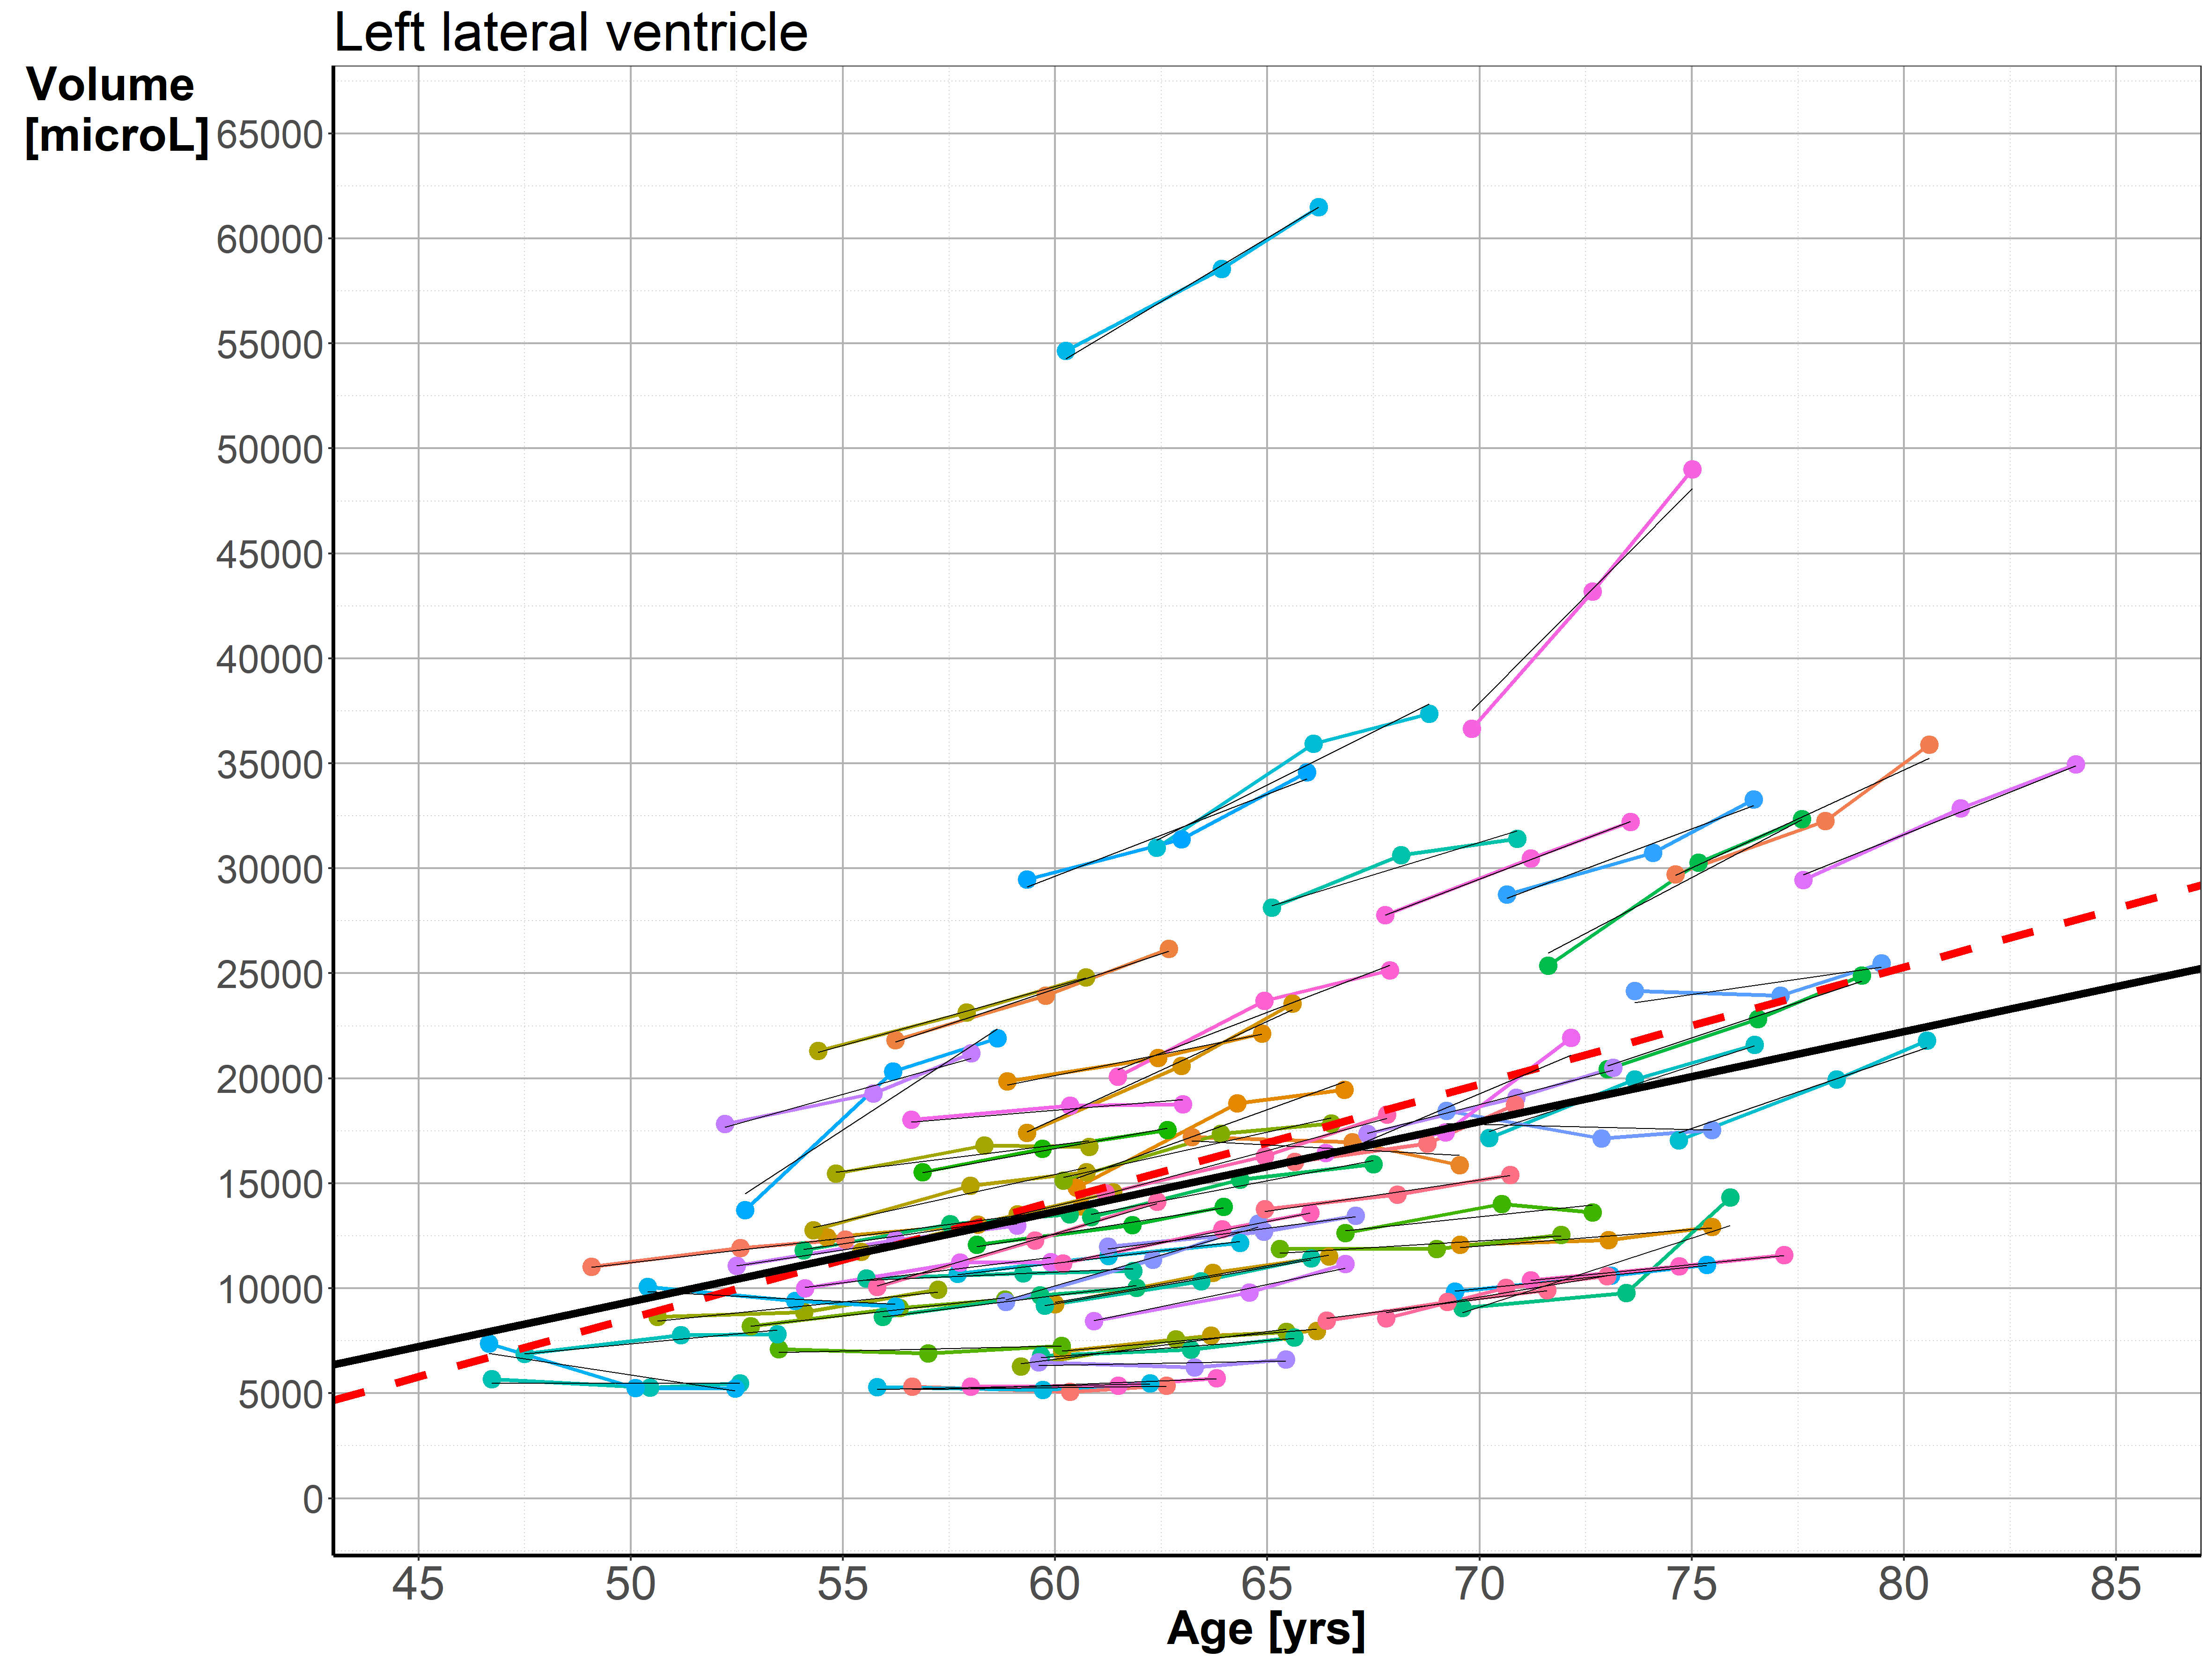

In [34]:
# %R print(g21)
Image(filename='../images/lvv_ri_rpy2_lmer_left_ventricle.png', width=900)

In [35]:
%%R

df <-  df.longR
mylm <- lm.1.R
mylmer <- lmer.1.R
mytitle <- title.1.R
#myfile <- myfile.1.R
#mytexfig <- mytexfig.1.R
#mytexfigg <- mytexfigg.1.R

g22 <- ggplot(data = df, aes(x = Age, y = Volume, group = Subject, colour = factor(Subject))) + geom_line(size=1)
# g11 <- g11 + scale_colour_discrete(name  ="Subject") + geom_point(pch=19, size = 4)
g22 <- g22 + scale_colour_discrete(name  ="Subject") + geom_point(pch=19, size = 4)
myX <- scale_x_continuous(limits = c(45, 85), breaks = seq(45, 85, 5), name = "Age [yrs]")
myY <- scale_y_continuous(limits = c(500, 65000), breaks = seq(0, 65000, 5000), name = "Volume\n [microL]")
# annottext <- paste("$\\hat{\\beta_0}=", round(beta0, 4), '; \\hat{\\beta_1}=', round(beta1, 5), '$', sep='') 
#annottext1 <- paste("$\\hat{\\beta_0}=", round(beta0, 2), '; \\hat{\\beta_1}=', round(beta1, 2), '$', sep='')
#annottext <- paste("${\\rm Vol}_{ij} = \\beta_0 + \\beta_1 {\\rm Age}_{ij} + (b_{0i} + b_{1i} {\\rm Age}_{ij}) + \\epsilon_{ij}$ where", annottext1, sep=" ")

#g11 <- g11 + annotate("text", x=65, y=1000,label= annottext, colour="black")
g22 <- g22 + geom_point(size = 1.0) + theme_bw() + myX + myY
g22 <- g22 + geom_abline(intercept = a0.R, slope = a1.R, linetype = "dashed", size=2.0, colour = "red")
g22 <- g22 + geom_abline(intercept = beta0.R, slope = beta1.R, linetype = "solid", size=2.0, colour = "black")
g22 <- g22 + labs(title = mytitle, fontsize = 32)
# Set title to twice the base font size
g22 <- g22 + theme(plot.title = element_text(size = rel(1.7)))
g22 <- g22 + theme(axis.line = element_line(size = 1, colour = "black", linetype = "solid"))
g22 <- g22 + theme(axis.text = element_text(size = rel(1.2)))
g22 <- g22 + theme(axis.title.y = element_text(size = rel(1.5), angle = 0))
g22 <- g22 + theme(axis.title.x = element_text(size = rel(1.5), angle = 0))
# g22 <- g22 + theme(legend.key = element_rect(colour = "black"))
# g22 <- g22 + theme(legend.title = element_text(size = rel(1.2), face = "italic"))
g22 <- g22 + theme(legend.position="none")
g22 <- g22 + theme(panel.grid.major = element_line(colour = "gray70"))
g22 <- g22 + theme(panel.grid.minor = element_line(colour = "gray80", linetype = "dotted"))
g22 <- g22 + theme(plot.background = element_rect(fill = "white"))

g22 <- g22 + theme(axis.text.x=element_text(size=24), axis.title.x=element_text(size=24,face="bold"))
g22 <- g22 + theme(axis.text.y=element_text(size=20), axis.title.y=element_text(size=24,face="bold"))
g22 <- g22 + theme(plot.title = element_text(size=28))


# Focus on individual trajectories; first fit a simple linear model to each trajectory
#g11 <- g11 + stat_smooth(method=lm, fullrange=FALSE, se=FALSE, linetype = "dashed")
# then add the mixed-effects fit
n <- length(b0i.R)
for (i in 1:n) {
  myx <-  df$Age[df$Wave==1][i]
  myxend <- df$Age[df$Wave==3][i]
  myy <- (beta0.R + b0i.R[i]) + (beta1.R + b1i.R[i])*myx
  myyend <- (beta0.R + b0i.R[i]) + (beta1.R + b1i.R[i])*myxend
  g22 <- g22 + annotate("segment", x = myx, xend = myxend, y = myy, yend = myyend, colour = "black", size = 0.3)
}
  
ggsave("../images/lvv_ri_rpy2_lmer_right_ventricle.pdf", width = 40, height = 30, units = "cm")
ggsave("../images/lvv_ri_rpy2_lmer_right_ventricle.png", width = 40, height = 30, units = "cm")


Error in ggplot(data = df, aes(x = Age, y = Volume, group = Subject, colour = factor(Subject))) : 
  could not find function "ggplot"


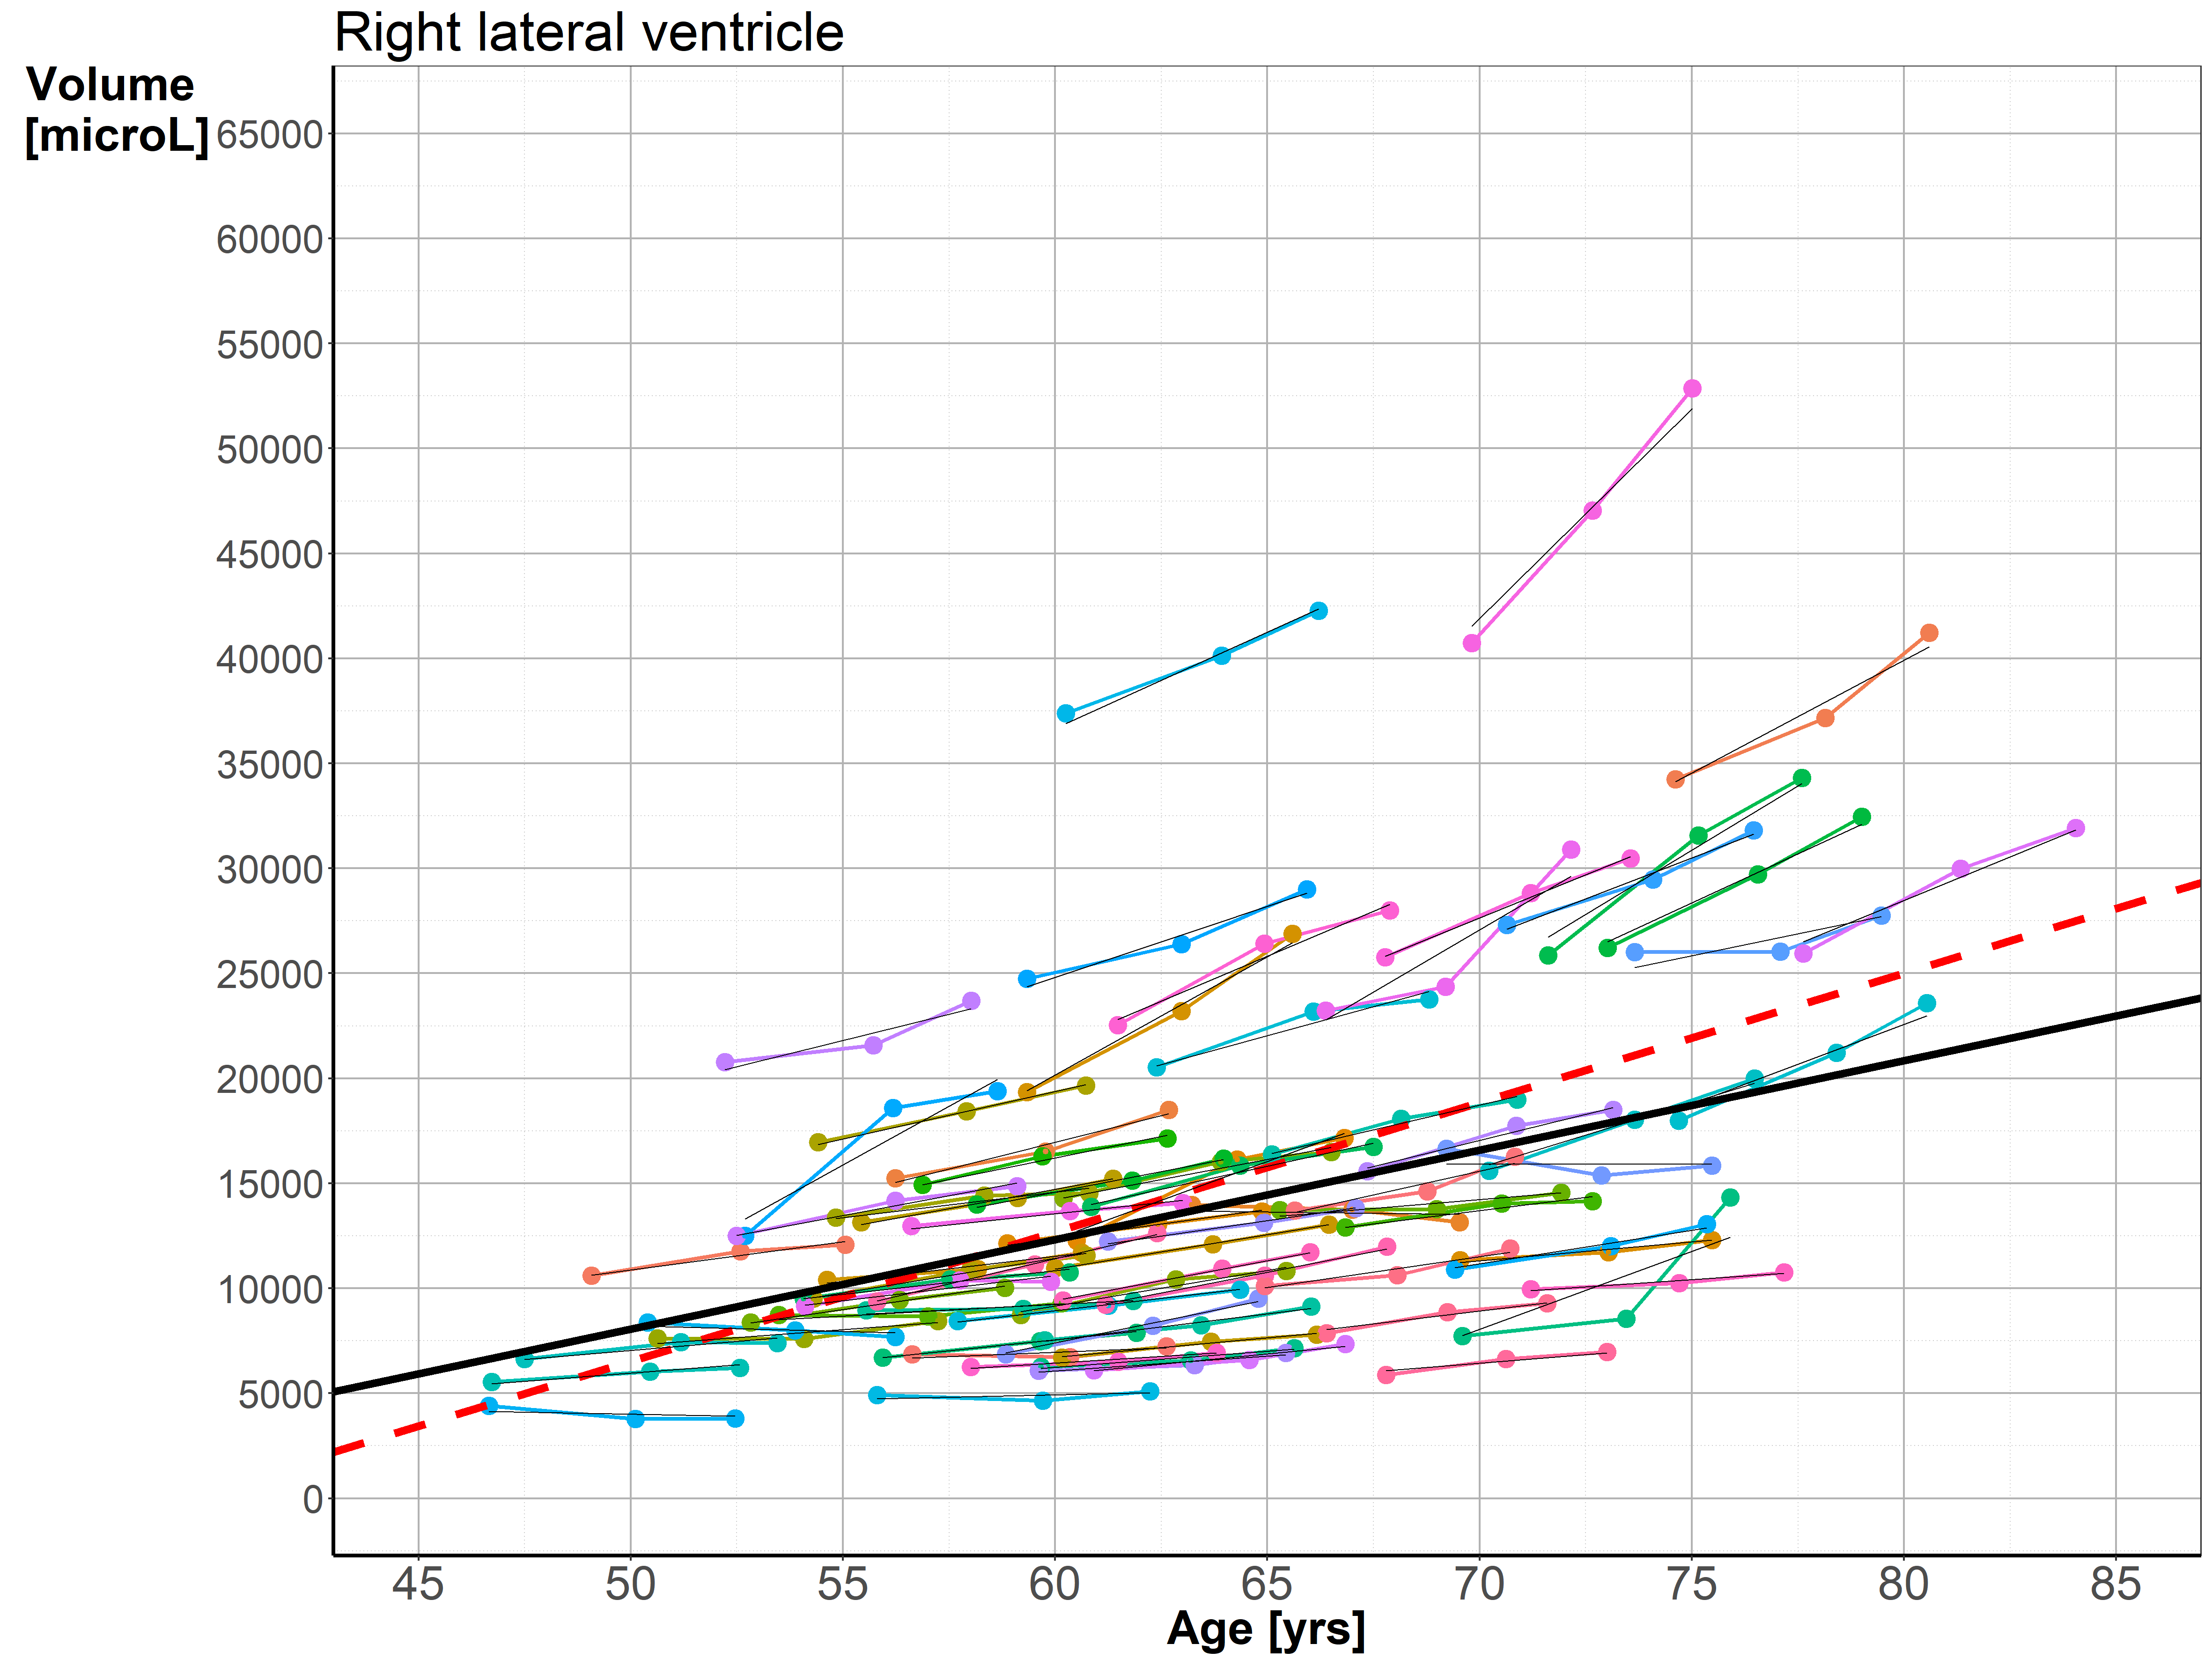

In [36]:
# %R print(g21)
Image(filename='../images/lvv_ri_rpy2_lmer_right_ventricle.png', width=900)

In [37]:
%R names(df.lmer.L)

array(['Subject', 'AcquisitionYearsW1', 'AcquisitionYearsW2',
       'AcquisitionYearsW3', 'Left.Lateral.Ventricle_W1',
       'Left.Lateral.Ventricle_W2', 'Left.Lateral.Ventricle_W3', 'b0i',
       'b1i', 'beta0plusb0i', 'beta1plusb1i', 'Sex', 'Stroop3'],
      dtype='<U25')

In [38]:
%%R 
x <- as.integer(substring(df.lmer.L$Subject,6, 7))
y <- df.lmer.L$Sex
df.lmer <- data.frame(x,y)
x_name <- "id"
y_name <- "Sex"
names(df.lmer) <- c(x_name,y_name)

# df.lmer = data.frame() # df.lmer.L[FALSE,]
# df.lmer$id = substring(df.lmer.L$Subject,6, 8)
# df.lmer$Sex = df.lmer.L$Sex

df.lmer$Age1 = df.lmer.L$AcquisitionYearsW1
df.lmer$Age2 = df.lmer.L$AcquisitionYearsW2
df.lmer$Age3 = df.lmer.L$AcquisitionYearsW3

df.lmer$b0iL = df.lmer.L$b0i
df.lmer$b1iL = df.lmer.L$b1i
df.lmer$beta0plusb0iL = df.lmer.L$beta0plusb0i
df.lmer$beta1plusb1iL = df.lmer.L$beta1plusb1i

df.lmer$b0iR = df.lmer.R$b0i
df.lmer$b1iR = df.lmer.R$b1i
df.lmer$beta0plusb0iR = df.lmer.R$beta0plusb0i
df.lmer$beta1plusb1iR = df.lmer.R$beta1plusb1i

#df.lmer$eTIV1 = df.lmer.L$eTIVw1
#df.lmer$eTIV2 = df.lmer.L$eTIVw2
#df.lmer$eTIV3 = df.lmer.L$eTIVw3

df.lmer$LatVentL1 = df.lmer.L$Left.Lateral.Ventricle_W1
df.lmer$LatVentL2 = df.lmer.L$Left.Lateral.Ventricle_W2
df.lmer$LatVentL3 = df.lmer.L$Left.Lateral.Ventricle_W3

df.lmer$LatVentR1 = df.lmer.R$Right.Lateral.Ventricle_W1
df.lmer$LatVentR2 = df.lmer.R$Right.Lateral.Ventricle_W2
df.lmer$LatVentR3 = df.lmer.R$Right.Lateral.Ventricle_W3

#df.lmer$Stroop13 = df.lmer.L$Stroop1
#df.lmer$Stroop23 = df.lmer.L$Stroop2
# df.lmer$Stroop33 = df.lmer.L$Stroop3
df.lmer$RI3 = df.lmer.L$Stroop3   # Response Inhibition, wave 3
#df.lmer$Stroop43 = df.lmer.L$Stroop4

#df.lmer$IQ1 = df.lmer.L$IQtot

In [39]:
%R print(colnames(df.lmer))

 [1] "id"            "Sex"           "Age1"          "Age2"         
 [5] "Age3"          "b0iL"          "b1iL"          "beta0plusb0iL"
 [9] "beta1plusb1iL" "b0iR"          "b1iR"          "beta0plusb0iR"
[13] "beta1plusb1iR" "LatVentL1"     "LatVentL2"     "LatVentL3"    
[17] "LatVentR1"     "LatVentR2"     "LatVentR3"     "RI3"          


```python
%%R
library(ggplot2)
library(GGally)

# data = df.selX[,2:9]
data = df.lmer

pm <- ggpairs(
    data, mapping = aes(color = Sex), 
    columns = c('Age3','b0iL','b0iR','b1iL','b1iR','RI3'),
  lower = list(
    continuous = 'smooth'
  ))

print(pm)

#         lower = list(
#     continuous = "smooth",
#     combo = ""facetdensity))

ggsave("../images/lvv_ri_rpy2_ggplot_ggpairs_X_by_sex.pdf", width = 30, height = 30, units = "cm")
ggsave("../images/lvv_ri_rpy2_ggplot_ggpairs_X_by_sex.png", width = 30, height = 30, units = "cm")
```

In [40]:
# Image(filename='../images/lvv_ri_rpy2_ggplot_ggpairs_X_by_sex.png', width=900)

###################### END of R STUFF ####################################

In [41]:
# Converting the R dataframes to Pandas DataFrames using Rpy2
# https://pandas.pydata.org/pandas-docs/stable/r_interface.html
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

pd_df_lmer = r['df.lmer']
pd_df_lmer.head().T.round(2)

,0,1,2,3,4
id,1,2,3,4,5
Sex,F,M,M,M,M
Age1,56.63,49.07,74.61,56.23,63.22
Age2,60.35,52.58,78.14,59.78,67
Age3,62.62,55.05,80.59,62.68,69.53
b0iL,15786.4,11459.9,-27879.9,-3972.69,35804.7
b1iL,-403.143,-192.311,504.248,242.65,-535.183
beta0plusb0iL,3728.31,-598.213,-39938,-16030.8,23746.7
beta1plusb1iL,25.5884,236.421,932.979,671.381,-106.451
b0iR,15196,10583.5,-32889,-381.043,28445.9


In [42]:
pd_df_lmer.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
id,74.0,37.50,21.51,1.00,19.25,37.50,55.75,74.00
Age1,74.0,60.75,7.25,46.66,55.61,59.88,66.39,77.63
Age2,74.0,64.28,7.21,50.11,59.32,63.56,69.23,81.33
Age3,74.0,66.81,7.19,52.46,61.86,66.02,72.09,84.05
b0iL,74.0,0.00,19108.39,-92465.22,-6894.05,3257.87,10098.43,35804.75
b1iL,74.0,-0.00,370.11,-736.38,-219.94,-84.96,213.99,1605.73
beta0plusb0iL,74.0,-12058.08,19108.39,-104523.31,-18952.13,-8800.22,-1959.65,23746.67
beta1plusb1iL,74.0,428.73,370.11,-307.65,208.79,343.77,642.72,2034.47
b0iR,74.0,-0.00,18775.33,-84955.14,-3666.57,5729.16,10642.13,28892.12
b1iR,74.0,-0.00,357.16,-478.81,-236.86,-96.86,81.32,1575.21


In [43]:
# dff = pd.read_csv(fn_data)
dff = pd_df_lmer.copy()
pd.DataFrame(dff.count())

,0
id,74
Sex,74
Age1,74
Age2,74
Age3,74
b0iL,74
b1iL,74
beta0plusb0iL,74
beta1plusb1iL,74
b0iR,74


In [44]:
#dff.beta1plusb1iLH - dff.b1iLH

In [45]:
# Derive new feature, related to wave1

def volFixed(x, a_f, b_f):
    '''
    Age at wave 1: x = dff.Age1
      a_f = dff.beta1L = dff.beta1plusb1iL - dff.b1iL
      b_f = dff.beta0plusb0iL - dff.b0iL
    Fixed effects: y_f = a_f x + b_f
    '''
    return a_f*x + b_f

    
def volDeviation(x, a_f, b_f, a_r, b_r):
    '''
    Age at wave 1: x = dff.Age1
    Fixed effects: y_f = a_f x + b_f
      a_f = dff.beta1L = dff.beta1plusb1iL - dff.b1iL
      b_f = dff.beta0plusb0iL - dff.b0iL
    Random effects: y_r = a_r x + b_r
      a_r = dff.beta1plusb1iL
      b_r = dff.beta0plusb0iL
    Vol_deviation = y_r - y_f
    '''

    y_f = a_f*x + b_f
    y_r = a_r*x + b_r
    return y_r - y_f

x = dff.Age1

# Left
a_f = dff.beta1plusb1iL - dff.b1iL
b_f = dff.beta0plusb0iL - dff.b0iL
a_r = dff.beta1plusb1iL
b_r = dff.beta0plusb0iL

print('LH fixed effects: (a_f, b_f) = (beta1L, beta0L) = (%.2f, %.2f)' % (a_f[0], b_f[0]))
dff['VdevL'] = volDeviation(x, a_f, b_f, a_r, b_r)
dff['Vfixed1L'] = volFixed(x, a_f, b_f)
dff['Vfixed1diffL'] = dff['LatVentL1'] - dff['Vfixed1L']


# Right
a_f = dff.beta1plusb1iR - dff.b1iR
b_f = dff.beta0plusb0iR - dff.b0iR
# a_r = dff.b1iR
a_r = dff.beta1plusb1iR
# b_r = dff.b0iR
b_r = dff.beta0plusb0iR

print('RH fixed effects: (a_f, b_f) = (beta1R, beta0R) = (%.2f, %.2f)' % (a_f[0], b_f[0]))
dff['VdevR'] = volDeviation(x, a_f, b_f, a_r, b_r)
dff['Vfixed1R'] = volFixed(x, a_f, b_f)
dff['Vfixed1diffR'] = dff['LatVentR1'] - dff['Vfixed1R']

LH fixed effects: (a_f, b_f) = (beta1L, beta0L) = (428.73, -12058.08)
RH fixed effects: (a_f, b_f) = (beta1R, beta0R) = (425.99, -13239.56)


In [46]:
pd.DataFrame(dff[['id', 'Age1', 'b0iL', 'b1iL', 'LatVentL1', 'Vfixed1L', 'Vfixed1diffL', 'VdevL']].round(2)).head()

,id,Age1,b0iL,b1iL,LatVentL1,Vfixed1L,Vfixed1diffL,VdevL
0,1,56.63,15786.39,-403.14,5321.4,12220.98,-6899.58,-7043.60
1,2,49.07,11459.87,-192.31,11038.6,8979.77,2058.83,2023.18
2,3,74.61,-27879.94,504.25,29718.4,19929.58,9788.82,9742.00
3,4,56.23,-3972.69,242.65,21830.1,12049.49,9780.61,9671.50
4,5,63.22,35804.75,-535.18,17205.1,15046.33,2158.77,1970.51


In [47]:
dff['errorL'] = dff['Vfixed1diffL'] - dff['VdevL']

In [48]:
pd.DataFrame(dff[['id', 'Age1', 'b0iR', 'b1iR', 'LatVentR1', 'Vfixed1R', 'Vfixed1diffR', 'VdevR']].round(2)).head()

,id,Age1,b0iR,b1iR,LatVentR1,Vfixed1R,Vfixed1diffR,VdevR
0,1,56.63,15195.99,-342.56,6855.2,10883.99,-4028.79,-4203.29
1,2,49.07,10583.50,-155.45,10611.6,7663.54,2948.06,2955.53
2,3,74.61,-32888.99,649.66,34241.0,18543.21,15697.79,15582.02
3,4,56.23,-381.04,83.66,15243.9,10713.60,4530.30,4323.03
4,5,63.22,28445.86,-450.13,13962.1,13691.24,270.86,-11.19


In [49]:
dff['errorR'] = dff['Vfixed1diffR'] - dff['VdevR']

In [50]:
pd.DataFrame(dff[['Age1', 'b0iL', 'b1iL', 'LatVentL1', 'Vfixed1L', 'Vfixed1diffL', 'VdevL', 'errorL']].mean().round(5))

,0
Age1,60.74824
b0iL,0.00000
b1iL,-0.00000
LatVentL1,14994.09730
Vfixed1L,13986.60548
Vfixed1diffL,1007.49182
VdevL,1002.89730
errorL,4.59452


In [51]:
pd.DataFrame(dff[['Age1', 'b0iR', 'b1iR', 'LatVentR1', 'Vfixed1R', 'Vfixed1diffR', 'VdevR', 'errorR']].mean().round(5))

,0
Age1,60.74824
b0iR,-0.00000
b1iR,-0.00000
LatVentR1,13777.27703
Vfixed1R,12638.30309
Vfixed1diffR,1138.97394
VdevR,1126.01433
errorR,12.95961


### Check summary statistics

In [52]:
pd_df = dff.copy()
pd_df.describe(include=[np.number]).round(2).T

,count,mean,std,min,25%,50%,75%,max
id,74.0,37.50,21.51,1.00,19.25,37.50,55.75,74.00
Age1,74.0,60.75,7.25,46.66,55.61,59.88,66.39,77.63
Age2,74.0,64.28,7.21,50.11,59.32,63.56,69.23,81.33
Age3,74.0,66.81,7.19,52.46,61.86,66.02,72.09,84.05
b0iL,74.0,0.00,19108.39,-92465.22,-6894.05,3257.87,10098.43,35804.75
b1iL,74.0,-0.00,370.11,-736.38,-219.94,-84.96,213.99,1605.73
beta0plusb0iL,74.0,-12058.08,19108.39,-104523.31,-18952.13,-8800.22,-1959.65,23746.67
beta1plusb1iL,74.0,428.73,370.11,-307.65,208.79,343.77,642.72,2034.47
b0iR,74.0,-0.00,18775.33,-84955.14,-3666.57,5729.16,10642.13,28892.12
b1iR,74.0,-0.00,357.16,-478.81,-236.86,-96.86,81.32,1575.21


In [53]:
pd.DataFrame([pd_df['id'], pd_df['Age3'], pd_df['VdevL'], pd_df['VdevR']]).round(1)


,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0
Age3,62.6,55.0,80.6,62.7,69.5,66.8,64.9,75.5,65.6,60.6,...,67.9,63.8,77.2,66.0,67.8,62.4,73.0,71.6,70.7,70.8
VdevL,-7043.6,2023.2,9742.0,9671.5,1970.5,1359.4,6505.4,-5823.2,4081.1,928.4,...,6117.5,-7586.4,-8080.7,-2518.2,300.3,-1753.0,-8167.0,-7840.0,-2119.9,-207.1
VdevR,-4203.3,2955.5,15582.0,4323.0,-11.2,185.8,209.4,-5154.3,7376.3,214.2,...,9862.5,-5289.7,-7203.1,-2904.3,-3567.0,-1130.4,-9560.8,-6996.2,-4400.2,-1105.4


#### Inital example using pandas dataframe, ggplot, and saving figure to disk

In [54]:
# dfL = pd.DataFrame(np.random.normal(0,1,size=(100, 3)), columns=list('ABC'))
# dfL['C'] = dfL['C'] + 2
# dfL.head()

In [55]:
# %%R -i dfL
# dfL %>% 
#   gather("Category", "X") %>%
#   ggplot(aes(x = Category, y = X, fill = Category)) +
#   geom_violin() +
#   stat_summary(fun.y=mean, color='black', geom='point', size = 3) +
#   labs(title = "Violin plot",
#          subtitle = "Means indicated as black dots",
#          captions = "Numbers generated in Numpy") +
#   theme_bw()

# ggsave("../figs/violin_plot.png")

In [56]:
# Image("../figs/violin_plot.png")

In [57]:
# Example: Converting a Pandas DataFrame to R dataframe using Rpy2

from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

import pandas as pd
import numpy as np
from datetime import datetime
n = 10
df = pd.DataFrame({
    "timestamp": [datetime.now() for t in range(n)],
    "value": np.random.uniform(-1, 1, n)
})
# df = pd_df[]
r_dataframe = pandas2ri.py2ri(df)
print(r_dataframe)
#pd_df_r = r["r_dataframe"]
#print(pd_df_r.head())
r_dataframe.head()

            timestamp      value
0 2018-11-09 06:53:07 -0.5640642
1 2018-11-09 06:53:07  0.9729296
2 2018-11-09 06:53:07  0.9220587
3 2018-11-09 06:53:07 -0.3291845
4 2018-11-09 06:53:07 -0.1587808
5 2018-11-09 06:53:07 -0.7646993
6 2018-11-09 06:53:07 -0.6249585
7 2018-11-09 06:53:07 -0.6950328
8 2018-11-09 06:53:07  0.8331223
9 2018-11-09 06:53:07 -0.9322312



timestamp,value
1541742787.000000,-0.564064
1541742787.000000,0.972930


### Select variables for analysis

In [58]:
pd_df.columns

Index(['id', 'Sex', 'Age1', 'Age2', 'Age3', 'b0iL', 'b1iL', 'beta0plusb0iL',
       'beta1plusb1iL', 'b0iR', 'b1iR', 'beta0plusb0iR', 'beta1plusb1iR',
       'LatVentL1', 'LatVentL2', 'LatVentL3', 'LatVentR1', 'LatVentR2',
       'LatVentR3', 'RI3', 'VdevL', 'Vfixed1L', 'Vfixed1diffL', 'VdevR',
       'Vfixed1R', 'Vfixed1diffR', 'errorL', 'errorR'],
      dtype='object')

In [59]:
myvars = [
    'Age3',
    # 'eTIV3',
    'b0iL',
    'b0iR',
    'b1iL',
    'b1iR',
    'VdevL',
    'VdevR',
    # 'Stroop13',
    # 'Stroop23',
    'RI3',
    #'Stroop43'
]

In [60]:
pd_df.groupby("Sex")[myvars].describe(include="all", percentiles = [0.5]).round(2).T

Sex                 F         M
Age3  count     48.00     26.00
      mean      66.42     67.54
      std        6.87      7.82
      min       52.57     52.46
      50%       65.54     66.76
      max       80.54     84.05
b0iL  count     48.00     26.00
      mean    1170.28  -2160.52
      std    19958.58  17601.38
      min   -92465.22 -43120.05
      50%     7354.95  -1084.00
      max    33378.49  35804.75
b0iR  count     48.00     26.00
      mean    1218.13  -2248.86
      std    20003.41  16400.38
      min   -84955.14 -34260.80
      50%     7775.14   2413.61
      max    28892.12  28445.86
b1iL  count     48.00     26.00
      mean     -59.82    110.43
      std      356.92    375.40
      min     -532.27   -736.38
      50%     -170.68     75.47
      max     1605.73    893.62
b1iR  count     48.00     26.00
      mean     -54.55    100.71
      std      364.94    325.31
      min     -478.81   -461.54
      50%     -184.81     25.82
      max     1575.21    701.79
VdevL count     48.00     26.00
      mean   -1193.91   5058.53
      std     5936.34   9200.25
      min    -8928.98  -5823.20
      50%    -1888.48   2994.11
      max    19647.13  40492.32
VdevR count     48.00     26.00
      mean    -774.73   4635.08
      std     5918.29   6637.85
      min    -9560.76  -5154.31
      50%    -1079.06   3527.05
      max    25026.26  24467.43
RI3   count     48.00     26.00
      mean      56.02     58.77
      std       14.95     13.62
      min       35.00     40.00
      50%       52.50     57.00
      max      102.00     94.00

### $\LaTeX$ related

In [61]:
print(pd_df.groupby("Sex")[myvars].describe(include="all", percentiles = [0.5]).round(2).T.to_latex())

\begin{tabular}{llrr}
\toprule
    & Sex &         F &         M \\
\midrule
Age3 & count &     48.00 &     26.00 \\
    & mean &     66.42 &     67.54 \\
    & std &      6.87 &      7.82 \\
    & min &     52.57 &     52.46 \\
    & 50\% &     65.54 &     66.76 \\
    & max &     80.54 &     84.05 \\
b0iL & count &     48.00 &     26.00 \\
    & mean &   1170.28 &  -2160.52 \\
    & std &  19958.58 &  17601.38 \\
    & min & -92465.22 & -43120.05 \\
    & 50\% &   7354.95 &  -1084.00 \\
    & max &  33378.49 &  35804.75 \\
b0iR & count &     48.00 &     26.00 \\
    & mean &   1218.13 &  -2248.86 \\
    & std &  20003.41 &  16400.38 \\
    & min & -84955.14 & -34260.80 \\
    & 50\% &   7775.14 &   2413.61 \\
    & max &  28892.12 &  28445.86 \\
b1iL & count &     48.00 &     26.00 \\
    & mean &    -59.82 &    110.43 \\
    & std &    356.92 &    375.40 \\
    & min &   -532.27 &   -736.38 \\
    & 50\% &   -170.68 &     75.47 \\
    & max &   1605.73 &    893.62 \\
b1iR & count & 

#### Cut and paste LaTeX code to new cell
%%latex  cell

substitute tabular with array as "MathJax doesn't implement tabular", and toprule, midrule with hline <br>
https://github.com/mathjax/mathjax-docs/wiki/LaTeX-Tabular-environment


### To HERE 11/8/2018